In [1]:
import yfinance as yf
import os
import time
import requests

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose



from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.base import BaseEstimator

from sklearn.metrics import mean_squared_error


# Análisis y Pronóstico de los Precios de Qualitas
## Resumen
## 1. Introducción

### Objetivo del proyecto
El objetivo de este proyecto es pronosticar los precios de **Qualitas** utilizando diversas técnicas de **series de tiempo**, abarcando desde modelos clásicos (*AR, MA, ARMA, ARIMA, SARIMA*) hasta técnicas avanzadas (*GARCH, ARMAX, Prophet, LSTM*).  
El análisis tiene como propósito comparar la precisión de los modelos mediante la métrica **RMSE** y evaluar la capacidad predictiva de cada enfoque, incorporando transformaciones, variables exógenas y técnicas de validación. 

### Importancia del análisis
El pronóstico preciso de precios es crucial para la toma de decisiones financieras, ya que permite identificar tendencias, evaluar riesgos y detectar patrones de volatilidad. Además, el uso de modelos avanzados (como LSTM) permite explorar el potencial del Machine Learning para series temporales, mientras que la incorporación de modelos de volatilidad (GARCH) mejora la comprensión del riesgo asociado.

---

## 2. Metodología

### 2.1 Obtención y preparación de datos
- Se utilizaron los datos históricos de Qualitas (Q) descargados con la librería `yfinance`, abarcando precios, volúmenes, dividendos y splits.  
- Se implementó una función para verificar la existencia del archivo local antes de realizar nuevas descargas, evitando problemas futuros por límites de la API.  
- Los datos fueron transformados para evaluar tanto precios como retornos, asegurando la estacionariedad donde fue necesario.  

### 2.2 Análisis exploratorio de datos (EDA)
Se realizaron los siguientes análisis para comprender la estructura de la serie temporal:
- **Gráfico QQ-plot:** evidenció que la distribución de los precios no seguía una distribución normal.  
- **Prueba de Dickey-Fuller:** confirmó la no estacionariedad de la serie original.  
- **Descomposición de la serie:** se separaron los componentes de tendencia, estacionalidad y residuo.  
- **ACF y PACF:** se analizaron las correlaciones para identificar el orden potencial de los modelos ARIMA.  
- **Técnicas de suavizado:** se aplicaron métodos de promedio móvil simple (*SMA*) y ponderado exponencialmente (*EWMA*) para evaluar la tendencia subyacente.  

---

## 3. Modelado

### 3.1 Modelos clásicos
Se probaron los siguientes modelos:
- **AR, MA y ARMA:**  
    - Se utilizó el *Likelihood Ratio Test (LRT)* para seleccionar el modelo más adecuado, concluyendo que el modelo **ARMA(2,2)** era suficiente, sin necesidad de agregar más parámetros.  
    - La prueba **Ljung-Box** confirmó la ausencia de autocorrelaciones significativas en los residuos, validando la idoneidad del modelo.  
- **ARIMA:**  
    - Se evaluaron múltiples configuraciones, destacando que **ARIMA(2,1,2)** obtuvo un RMSE de **40.43**, mejorando en un **40%** el error respecto al ARIMA(1,1,1).  
- **SARIMA:**  
    - Aunque la serie no presentaba estacionalidad, se probó SARIMA para validar su comportamiento, sin mejoras significativas.  

### 3.2 Modelos de volatilidad
Se exploraron modelos para capturar la volatilidad de los rendimientos:
- **ARCH**: modeló la heterocedasticidad de los rendimientos.  
- **GARCH:**  
    - Se compararon GARCH(1,1) y GARCH(1,2), concluyendo que **GARCH(1,2)** capturaba mejor la memoria de la varianza, indicando que la volatilidad de Qualitas dependía de dos lags pasados.  
    - El modelo GARCH(1,2) fue superior, mejorando la precisión del modelado del riesgo.  

### 3.3 Modelos con variables exógenas
Se incorporó el **IPC México** como variable exógena para evaluar el impacto de un índice bursátil:
- **ARMAX:** comparado con ARMA, mostró una leve mejora en la precisión del pronóstico, aunque con limitaciones para predicciones a largo plazo debido a la necesidad de conocer las variables exógenas futuras.  

### 3.4 Modelos avanzados
Se aplicaron técnicas más complejas:
- **Prophet:**  
    - Ofreció un RMSE de **25.146**, logrando una mejora del **28%** respecto al mejor ARIMA.  
- **LSTM:**  
    - Se aplicó un modelo LSTM con una ventana temporal de **20 días** (frecuencia de días hábiles), logrando un RMSE de **5.974** para predicciones directas.  
    - Se probó la predicción recursiva, acumulando error, lo que resultó en un RMSE de **60.822** al pronosticar **357 días** hacia el futuro.  
    - Se concluyó que el LSTM es más preciso para pronósticos de corto plazo.  

---

## 4. Comparación de resultados

| **Modelo**       | **Frecuencia**         | **RMSE**      | **Observaciones**                      |
|------------------|------------------------|---------------|---------------------------------------|
| ARIMA(2,1,2)     | Diaria (hábil)         | 40.43         | Mejor modelo clásico                  |
| SARIMA           | Diaria (hábil)         | 42.31         | No mostró mejoras significativas      |
| Prophet          | Diaria (hábil)         | 25.15         | Redujo el RMSE en un 28% respecto ARIMA |
| LSTM (directo)   | Ventana de 20 días     | 5.97          | Mejor modelo general                  |
| LSTM (recursivo) | 357 días               | 60.82         | Acumulación de error a largo plazo    |
| ARMAX (rend.)    | Diaria (hábil)         | 1.93          | Leve mejora respecto a ARMA           |
| GARCH(1,2)       | Volatilidad (rend.)    | No RMSE       | Mejor para modelar el riesgo          |

**Conclusiones clave:**  
- **LSTM directo** obtuvo el menor RMSE (5.974), pero solo para predicciones a corto plazo.  
- **Prophet** superó a ARIMA en precisión, reduciendo el RMSE en un 28%.  
- **GARCH(1,2)** modeló mejor la volatilidad, mostrando que la varianza depende de dos lags.  
- Los modelos con **variables exógenas (ARMAX)** ofrecen mejoras, pero dificultan la predicción futura debido a la dependencia de variables desconocidas.  

---

## 5. Conclusiones y Recomendaciones

### Conclusiones
- Los modelos **clásicos (ARIMA)** fueron efectivos, pero limitados en precisión frente a enfoques más avanzados.  
- **Prophet** resultó ser un modelo robusto y preciso para la serie temporal, superando a ARIMA.  
- **LSTM** demostró ser el modelo más preciso a corto plazo, aunque su precisión disminuyó en predicciones a largo plazo debido a la acumulación de error.  
- El uso de **GARCH** fue clave para modelar la volatilidad, lo que puede ser útil para la gestión de riesgos.  

### Recomendaciones
- Para predicciones de corto plazo, utilizar **LSTM con ventanas de 20 días**.  
- Para pronósticos a mediano plazo, **Prophet** es la mejor opción, considerando su menor RMSE frente a ARIMA.  
- En análisis de riesgos, implementar **GARCH(1,2)** para capturar mejor la volatilidad.  
- En futuros análisis, explorar técnicas **ensemble** que combinen múltiples modelos para reducir el error acumulativo.  
- Establecer un horizonte de pronóstico uniforme (ej. 5 días) para comparar los modelos de forma equitativa.  


# Descarga histórica de precios Q

In [2]:
# Definir el ticker de Quálitas en la Bolsa Mexicana de Valores
# Configuración inicial
ticker_symbol = "Q.MX"
csv_filename = "qualitas_prices.csv"
start_date = "2015-07-17"

# Verificar si el CSV existe
if os.path.exists(csv_filename):
    print(f"Cargando datos locales desde {csv_filename}...")
    df_Q_all = pd.read_csv(csv_filename, index_col="Date", parse_dates=True)
else:
    print("Descargando datos desde Yahoo Finance...")
    
    # Configurar sesión con headers
    session = requests.Session()
    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
    })
    
    ticker = yf.Ticker(ticker_symbol, session=session)
    max_retries = 3
    retry_delay = 5
    success = False
    
    for attempt in range(max_retries):
        try:
            df_Q_all = ticker.history(start=start_date, end=None)
            df_Q_all.to_csv(csv_filename)
            print(f"Datos guardados en {csv_filename}.")
            success = True
            break
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429:
                print(f"Intento {attempt+1}: Rate limit. Esperando {retry_delay} segundos...")
                time.sleep(retry_delay)
                retry_delay *= 2
            else:
                print(f"Error HTTP: {e}")
                break
        except Exception as e:
            print(f"Error inesperado: {str(e)}")
            break
    
    if not success:
        print("No se pudo descargar. Verifica el ticker o espera unas horas.")

# Mostrar datos
if 'df_Q_all' in locals():
    print("\nEjemplo de datos:")
    print(df_Q_all.head())
else:
    print("No hay datos disponibles.")

Cargando datos locales desde qualitas_prices.csv...

Ejemplo de datos:
                                Open       High        Low      Close  Volume  \
Date                                                                            
2015-07-17 00:00:00-05:00  21.103882  21.118946  20.712232  20.953247   34299   
2015-07-20 00:00:00-05:00  20.719763  21.156603  20.712232  20.915588   79808   
2015-07-21 00:00:00-05:00  20.938181  20.938181  20.719762  20.870396   59068   
2015-07-22 00:00:00-05:00  20.877930  21.043628  20.712232  20.953247  378294   
2015-07-23 00:00:00-05:00  20.877927  21.005967  20.712230  20.923119  145393   

                           Dividends  Stock Splits  
Date                                                
2015-07-17 00:00:00-05:00        0.0           0.2  
2015-07-20 00:00:00-05:00        0.0           0.0  
2015-07-21 00:00:00-05:00        0.0           0.0  
2015-07-22 00:00:00-05:00        0.0           0.0  
2015-07-23 00:00:00-05:00        0.0       

In [3]:
print(df_Q_all.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 2015-07-17 00:00:00-05:00 to 2025-02-26 00:00:00-06:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2419 non-null   float64
 1   High          2419 non-null   float64
 2   Low           2419 non-null   float64
 3   Close         2419 non-null   float64
 4   Volume        2419 non-null   int64  
 5   Dividends     2419 non-null   float64
 6   Stock Splits  2419 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 151.2+ KB
None


In [4]:
df_Q_close= df_Q_all["Close"].to_frame()
# Cambiar la columna "Close" a "Q.MX"
df_Q_close = df_Q_close.rename(columns={"Close": "Q.MX"})
display(df_Q_close)

,Q.MX
Date,
2015-07-17 00:00:00-05:00,20.953247
2015-07-20 00:00:00-05:00,20.915588
2015-07-21 00:00:00-05:00,20.870396
2015-07-22 00:00:00-05:00,20.953247
2015-07-23 00:00:00-05:00,20.923119
...,...
2025-02-20 00:00:00-06:00,193.000000
2025-02-21 00:00:00-06:00,186.649994
2025-02-24 00:00:00-06:00,196.330002


In [5]:
print(df_Q_all.info())
print("-"*50)
#print(historico_Q.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 2015-07-17 00:00:00-05:00 to 2025-02-26 00:00:00-06:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2419 non-null   float64
 1   High          2419 non-null   float64
 2   Low           2419 non-null   float64
 3   Close         2419 non-null   float64
 4   Volume        2419 non-null   int64  
 5   Dividends     2419 non-null   float64
 6   Stock Splits  2419 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 151.2+ KB
None
--------------------------------------------------


## Validación de datos con el origen

In [6]:
print(df_Q_close.tail())


                                 Q.MX
Date                                 
2025-02-20 00:00:00-06:00  193.000000
2025-02-21 00:00:00-06:00  186.649994
2025-02-24 00:00:00-06:00  196.330002
2025-02-25 00:00:00-06:00  195.600006
2025-02-26 00:00:00-06:00  200.580002


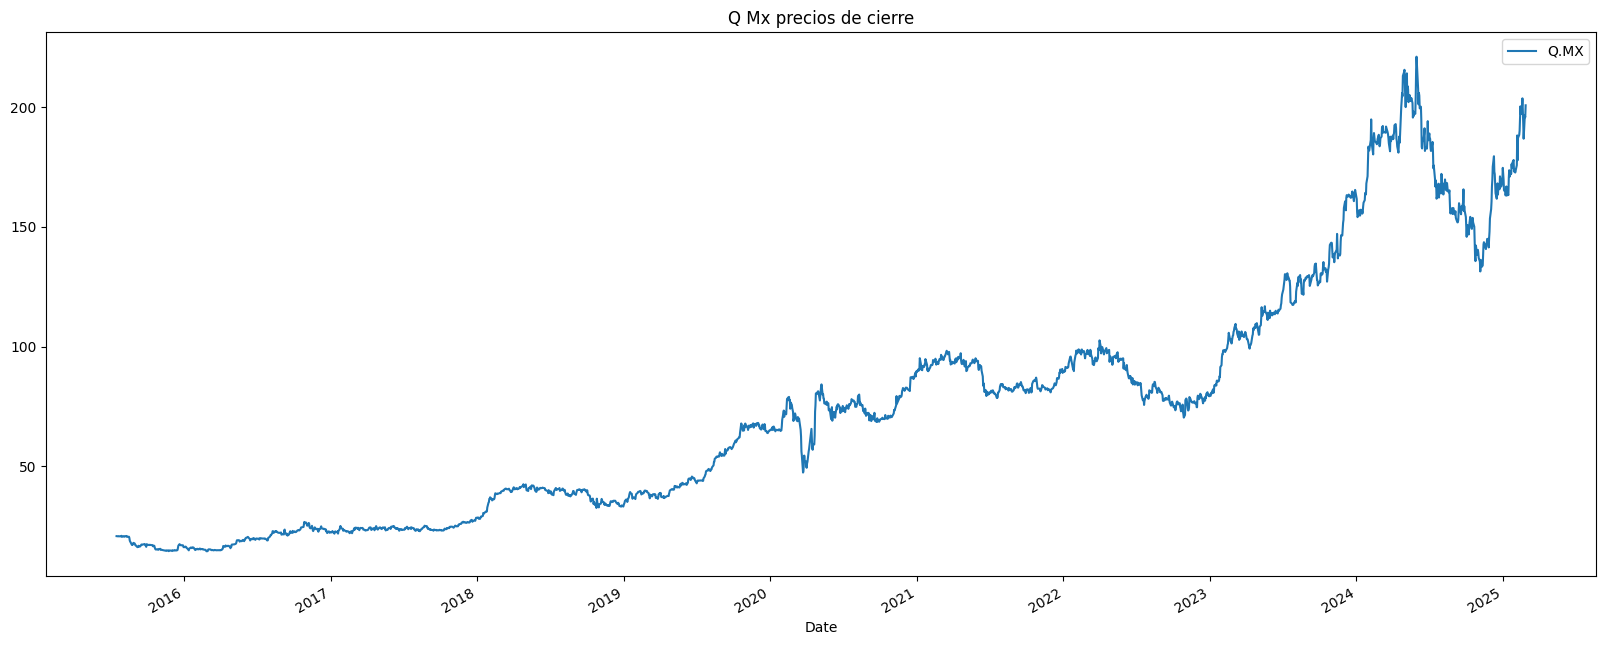

In [7]:
df_Q_close.plot(figsize= (20,8), title= "Q Mx precios de cierre")
plt.show()

## QQ plot (gráfico cuartil-cuartil)

📌 ¿Cómo funciona un QQ Plot?
- Ordena los datos de la serie en orden ascendente.
- Calcula los cuantiles teóricos de una distribución de referencia (normal, t-student, etc.).
- Grafica los cuantiles empíricos (de la serie) contra los teóricos.
- Si los puntos forman una línea recta (45°), la serie sigue la distribución teórica.


In [8]:
print(df_Q_close.describe())

              Q.MX
count  2419.000000
mean     73.386173
std      49.778224
min      14.656729
25%      26.807457
50%      70.617722
75%      94.949661
max     220.839996


In [9]:
from scipy import stats as st

In [10]:
# Si df_Q_close es un DataFrame, extraer la serie correcta
df_Q_close_ts = df_Q_close.squeeze()  # Convierte DataFrame de 1 columna en Serie

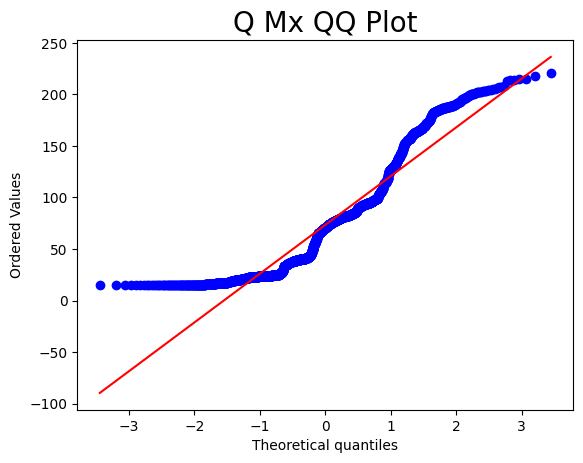

In [11]:
st.probplot(df_Q_close_ts, plot= plt)
plt.title("Q Mx QQ Plot", size= 20)
plt.show()

**Conclusión:** No se distribuye de forma normal(campana de gauss) ya que se desvian de la linea roja (45grados)

## División de entrenamiento y test

In [12]:
# Ordenar por fecha (si no lo está ya)
df_Q_close = df_Q_close.sort_index(ascending=True)

# Dividir manualmente conservando el orden temporal
size = int(len(df_Q_close) * 0.8)
train = df_Q_close.iloc[:size]
test = df_Q_close.iloc[size:]

display(train)
print("-"*50)
display(test)


,Q.MX
Date,
2015-07-17 00:00:00-05:00,20.953247
2015-07-20 00:00:00-05:00,20.915588
2015-07-21 00:00:00-05:00,20.870396
2015-07-22 00:00:00-05:00,20.953247
2015-07-23 00:00:00-05:00,20.923119
...,...
2023-03-16 00:00:00-06:00,104.463730
2023-03-17 00:00:00-06:00,103.332848
2023-03-21 00:00:00-06:00,106.274971


--------------------------------------------------


,Q.MX
Date,
2023-03-24 00:00:00-06:00,104.546471
2023-03-27 00:00:00-06:00,103.958046
2023-03-28 00:00:00-06:00,105.272812
2023-03-29 00:00:00-06:00,104.757942
2023-03-30 00:00:00-06:00,106.072701
...,...
2025-02-20 00:00:00-06:00,193.000000
2025-02-21 00:00:00-06:00,186.649994
2025-02-24 00:00:00-06:00,196.330002


# Ruido Blanco

In [13]:
wn = np.random.normal(loc= df_Q_close.mean(), scale= df_Q_close.std(), size= len(df_Q_close))

In [14]:
df_Q_close["wn"]= wn

In [15]:
df_Q_close.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 2015-07-17 00:00:00-05:00 to 2025-02-26 00:00:00-06:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q.MX    2419 non-null   float64
 1   wn      2419 non-null   float64
dtypes: float64(2)
memory usage: 121.2+ KB


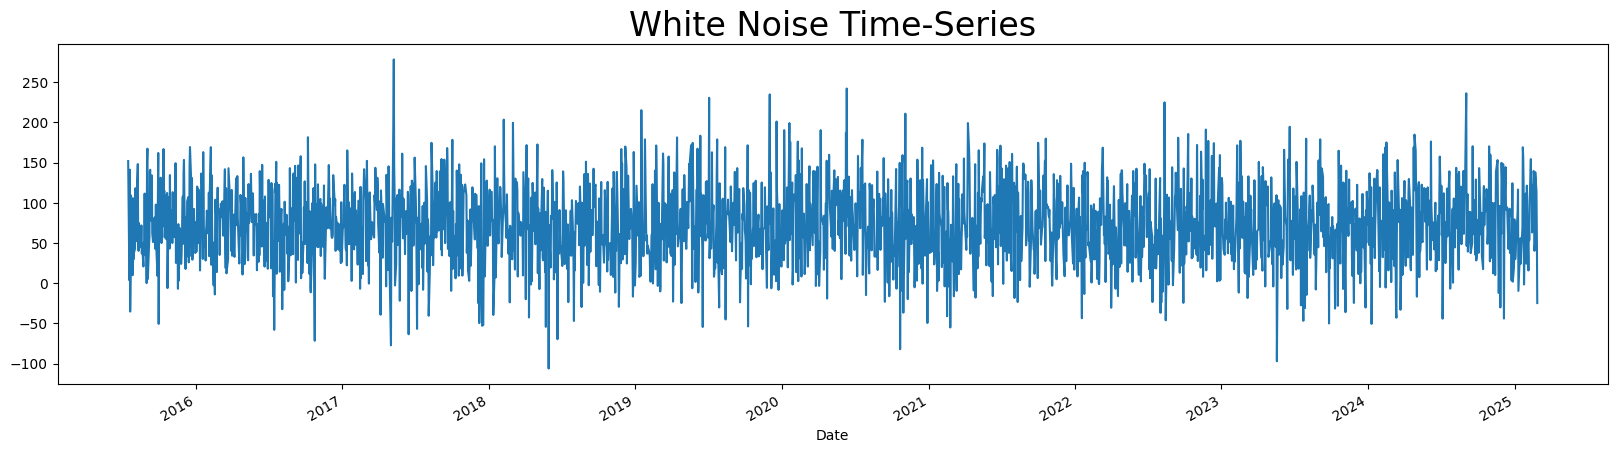

In [16]:
df_Q_close["wn"].plot(figsize= (20,5))
plt.title("White Noise Time-Series", size= 24)
plt.show()

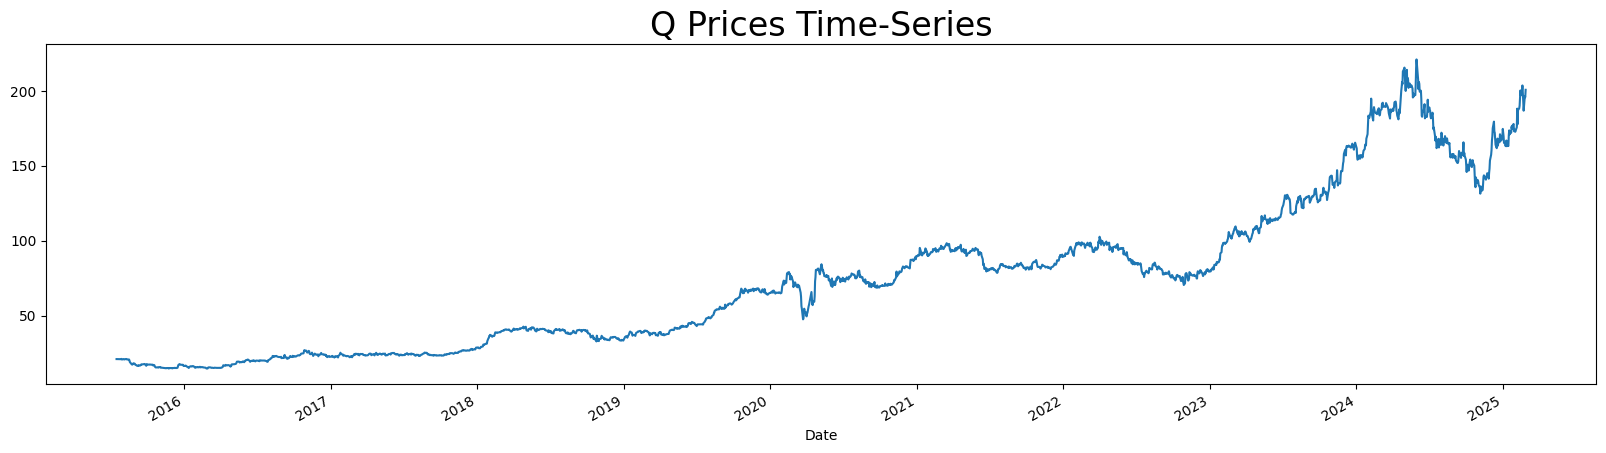

In [17]:
df_Q_close["Q.MX"].plot(figsize= (20,5))
plt.title("Q Prices Time-Series", size= 24)
plt.show()

# Caminata Aleatoria

Un tipo especial de serie temporal donde los valores tienden a **persistir en el tiempo** y las diferencias entre períodos son simplemente **ruido blanco**

In [18]:
#generaremos pasos para comparar con nuestros valores de Q, con media cero y desviación estandar 1.
steps= np.random.normal(loc= 0, scale= 1, size= len(df_Q_close))

# Ponemos el primer elemento a 0 para que el precio inicial sea el que pongamos nosotros
steps[0] = 0

# Simulando los precios P coun precio inicial de ...
P = 0 + np.cumsum(steps)

<function matplotlib.pyplot.show(close=None, block=None)>

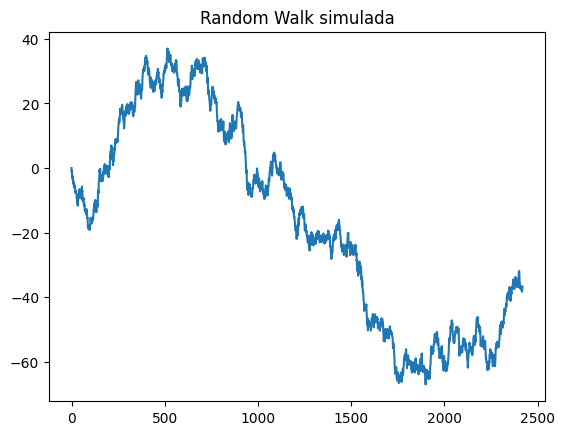

In [19]:
plt.plot(P)
plt.title("Random Walk simulada")
plt.show

# Serie Estacionaria o estacionariedad

Una serie de tiempo se considera estacionaria si sus propiedades estadísticas (como la media, la varianza y la autocovarianza) no cambian con el tiempo. Esto significa que la serie no tiene tendencia ni patrones cíclicos a largo plazo.

#### **1. Serie estacionaria y no estacionaria**

- Una serie es **estacionaria** cuando es estable a lo largo del tiempo, es decir, cuando la media y la varianza son constantes en el tiempo y además no presenta tendencias.

- Una **serie no estacionaria** serán aquellas cuya tendencia y/o variabilidad cambian en el tiempo o sea no permanecen constantes. Los cambios en la media van a determinar una tendencia una tendencia a crecer o decrecer a lo largo del plazo, por lo que no oscilaría alrededor de un valor constante.

#### **2. Medición de la Estacionalidad: Fuerte vs. Débil**

La estacionalidad se clasifica como **fuerte** o **débil** en función de su magnitud relativa respecto al ruido y la tendencia.

##### **Estacionalidad Débil**
- Matemáticamente, se cumple:
$$
\frac{\text{Var}(S_t)}{\text{Var}(R_t)} \approx 1 \quad \text{o} \quad \frac{\text{Var}(S_t)}{\text{Var}(R_t)} < 1
$$
- Es decir, la varianza de la estacionalidad es comparable o menor que la varianza del residuo.

Un proceso estocástico $Y_t$ se considera **débilmente estacionario** (o estacionario en sentido amplio) si cumple las siguientes tres condiciones:

1. **Media constante**:
   $$
   \mathbb{E}[Y_t] = \mu \quad \text{(la media no depende del tiempo $t$)}
   $$

2. **Varianza constante**:
   $$
   \text{Var}(Y_t) = \sigma^2 \quad \text{(la varianza no depende del tiempo $t$)}
   $$

3. **Covarianza dependiente solo del retardo (lag)**:
   $$
   \text{Cov}(Y_t, Y_{t+k}) = \gamma(k) \quad \text{(la covarianza depende solo de la diferencia $k$, no de $t$)}
   $$

Estas condiciones implican que las propiedades estadísticas del proceso (media, varianza y covarianza) no cambian con el tiempo, lo que es una característica clave de la **estacionalidad débil**.

##### **Estacionalidad Fuerte**
- Matemáticamente, se cumple:
$$
\frac{\text{Var}(S_t)}{\text{Var}(R_t)} \gg 1
$$
- Es decir, la varianza de la estacionalidad es mucho mayor que la varianza del residuo.
- Ejemplo: En el ámbito bursátil, el "January Effect" (aumento de precios en enero) es un patrón estacional fuerte porque es consistente y significativo.

En contraste, un proceso **fuertemente estacionario** (o estacionario en sentido estricto) requiere que la distribución conjunta de cualquier conjunto de observaciones $Y_{t_1}, Y_{t_2}, \dots, Y_{t_n}$ sea la misma que la de $Y_{t_1+k}, Y_{t_2+k}, \dots, Y_{t_n+k}$ para cualquier $k$. Esto es más restrictivo que la estacionalidad débil.

##### **3. Importancia de la Estacionariedad**
* Muchos modelos de series de tiempo (como ARIMA) asumen que la serie es estacionaria.

* Si una serie no es estacionaria, se pueden aplicar transformaciones (como diferenciación o logaritmos) para lograr estacionariedad.

## La serie de Qualitas es no estacionaria

Hipótesis:
* Hipótesis nula (
$H_0$
 ): La serie tiene una raíz unitaria (es no estacionaria).

* Hipótesis alternativa (
$H_1$
): La serie no tiene una raíz unitaria (es estacionaria).


In [20]:
# Aplicar la prueba de Dickey-Fuller

adfuller_Q= sts.adfuller(df_Q_close["Q.MX"])
print(adfuller_Q)

print("-"*50)

print(f"Estadístico de prueba: {adfuller_Q[0]}")
print(f"Valor p: {adfuller_Q[1]}")
print(f"Valores críticos: {adfuller_Q[4]}")

# Interpretación
if adfuller_Q[1] < 0.05:
    print("Rechazamos la hipótesis nula: la serie es estacionaria.")
else:
    print("No rechazamos la hipótesis nula: la serie es no estacionaria.")


(0.7543902844853364, 0.9908631033039145, 19, 2399, {'1%': -3.4330787665210787, '5%': -2.8627455322464477, '10%': -2.5674117552749243}, 9609.831021150567)
--------------------------------------------------
Estadístico de prueba: 0.7543902844853364
Valor p: 0.9908631033039145
Valores críticos: {'1%': -3.4330787665210787, '5%': -2.8627455322464477, '10%': -2.5674117552749243}
No rechazamos la hipótesis nula: la serie es no estacionaria.


# Estacionalidad

**Definición:**
La estacionalidad se refiere a patrones o fluctuaciones recurrentes en una serie de tiempo que ocurren en intervalos regulares. Estos patrones están asociados con factores cíclicos, como las estaciones del año, meses, semanas o días específicos.

#### **1. Componentes de una Serie de Tiempo Aditiva**

Una serie de tiempo $Y_t$ puede descomponerse en varios componentes:

$$
Y_t = T_t + S_t + R_t
$$

- $T_t$: **Tendencia** (componente de largo plazo).
- $S_t$: **Estacionalidad** (patrones repetitivos en intervalos regulares).
- $R_t$: **Residuo** (componente aleatorio o ruido).

#### **2. Descomposición Multiplicativa**

En la descomposición multiplicativa, se asume que la serie de tiempo $Y_t$ es el producto de sus componentes:
$$
Y_t = T_t * S_t * R_t
$$

- $T_t$: **Tendencia** (componente de largo plazo).
- $S_t$: **Estacionalidad** (patrones repetitivos en intervalos regulares).
- $R_t$: **Residuo** (componente aleatorio o ruido).

#### **Conclusión**
* Descomposición Aditiva: $Y_t = T_t + S_t + R_t$ . Usa cuando la estacionalidad es constante.

* Descomposición Multiplicativa: $Y_t = T_t * S_t * R_t$. Usa cuando la estacionalidad es proporcional al nivel de la serie.


In [21]:
# Paso 1: Convertir el índice a datetime con utc=True para manejar tz-aware
df_Q_close.index = pd.to_datetime(df_Q_close.index, utc=True)

# Paso 2: Quitar huso horario
df_Q_close.index = df_Q_close.index.tz_localize(None)

# Paso 3: Normalizar fechas (eliminar horas, minutos y segundos)
df_Q_close.index = df_Q_close.index.normalize()  # <--- ¡Clave aquí!

# Paso 4: Establecer frecuencia a días hábiles (usa "B" en mayúscula)
df_Q_close = df_Q_close.asfreq("B")

df_Q_close = df_Q_close.fillna(method= "bfill")

# Verificar
display(df_Q_close.head())



C:\Users\snede\AppData\Local\Temp\ipykernel_13168\3261341149.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_Q_close = df_Q_close.fillna(method= "bfill")


,Q.MX,wn
Date,,
2015-07-17,20.953247,151.930862
2015-07-20,20.915588,3.692778
2015-07-21,20.870396,141.194921
2015-07-22,20.953247,-35.290687
2015-07-23,20.923119,5.886043


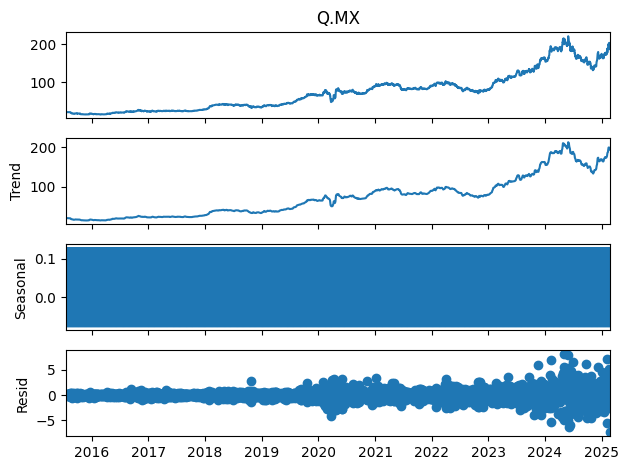

In [22]:
s_dec_additive= seasonal_decompose(df_Q_close["Q.MX"], model= "additive")
s_dec_additive.plot()
plt.show()

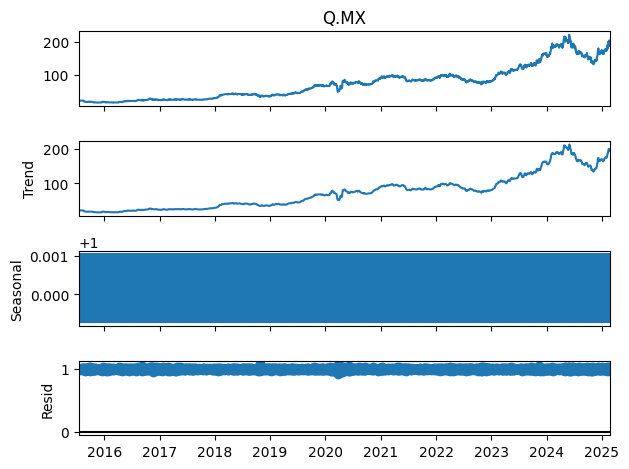

In [23]:
s_dec_multiplicative= seasonal_decompose(df_Q_close["Q.MX"], model= "multiplicative")
s_dec_multiplicative.plot()
plt.show()

# Filtro Hodrick Prescott

Es una técnica ampliamente utilizada en economía y análisis de series de tiempo para descomponer una serie en dos componentes:

1. Tendencia ($T_t$): Representa el movimiento a largo plazo.

2. Componente cíclico ($C_t$): Representa las fluctuaciones alrededor de la tendencia (como ciclos económicos o variaciones de corto plazo).

Es especialmente útil para analizar series macroeconómicas (como el PIB) o financieras, donde interesa separar la señal subyacente del "ruido" o fluctuaciones temporales.

## ¿Cómo funciona el Filtro HP?

El filtro Hodrick-Prescott (HP) resuelve un problema de optimización que busca minimizar la siguiente función:

$$
\min_{T_t} \left( \sum_{t=1}^n (Y_t - T_t)^2 + \lambda \sum_{t=2}^{n-1} [(T_{t+1} - T_t) - (T_t - T_{t-1})]^2 \right)
$$

Donde:
- $Y_t$: Serie de tiempo original.
- $T_t$: Tendencia estimada.
- $\lambda$: Parámetro de suavizado (controla qué tan suave es la tendencia).

---

### Interpretación del Parámetro $\lambda$

El parámetro $\lambda$ controla el equilibrio entre ajustar la tendencia a la serie original y suavizar las fluctuaciones. Su valor depende de la frecuencia de los datos:

1. **$\lambda$ alto**:
   - La tendencia es más suave (se penalizan fuertemente las variaciones en la tendencia).
   - Ejemplo: $\lambda = 1600$ para datos **trimestrales** (valor estándar en macroeconomía).

2. **$\lambda$ bajo**:
   - La tendencia se ajusta más a la serie original (menos suavizada).
   - Ejemplo: $\lambda = 6.25$ para datos **anuales**, $\lambda = 129,600$ para datos **mensuales**.



## Aplicación del Filtro HP a Series con Frecuencia de Días Hábilies
### 1. ¿Tiene sentido aplicar el Filtro HP a datos diarios?
Sí, el Filtro HP puede aplicarse a datos diarios, pero debes considerar lo siguiente:

* Objetivo: Si buscas separar la tendencia de las fluctuaciones de corto plazo, el Filtro HP es útil.

* Frecuencia: Los datos diarios tienen una frecuencia más alta que los datos trimestrales o anuales, por lo que el valor de $λ$ debe ajustarse.

### 2. Ajuste del Parámetro $\lambda$ para Días Hábilies

El parámetro $\lambda$ controla el suavizado de la tendencia. Para datos diarios, el valor de $\lambda$ debe ser mayor que el usado para datos trimestrales o anuales, ya que hay más observaciones y más variabilidad en los datos.

#### Valores de $\lambda$ comunes
- **Datos anuales**: $\lambda = 6.25$.
- **Datos trimestrales**: $\lambda = 1600$ (valor estándar en macroeconomía).
- **Datos mensuales**: $\lambda = 129,600$.
- **Datos diarios**: $\lambda = 365^4 \approx 1.77 \times 10^{10}$ (basado en la regla $\lambda = 1600 \times (\text{frecuencia})^4$).

Sin embargo, para datos de días hábiles (excluyendo fines de semana y festivos), una regla práctica es usar:
$$
\lambda = 1600 \times (\text{frecuencia})^4
$$
Donde la frecuencia es el número de días hábiles en un año (aproximadamente 252).

Por lo tanto:
$$
\lambda = 1600 \times (252)^4 \approx 6.45 \times 10^{11}
$$

In [24]:
from statsmodels.tsa.filters.hp_filter import hpfilter

Q_cycle, Q_trend = hpfilter(df_Q_close["Q.MX"], lamb= 1600*((252)**(4)))

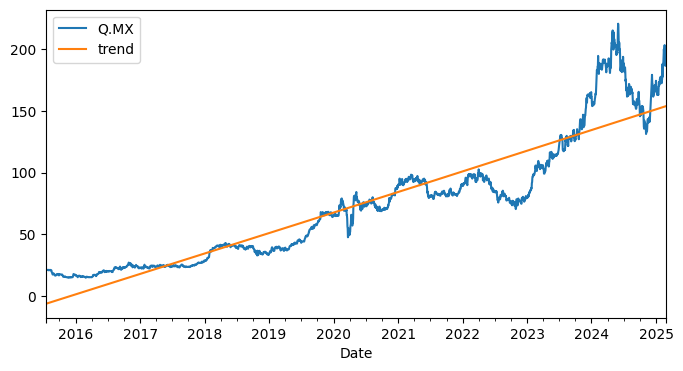

In [25]:
df_Q_close["trend"]= Q_trend
df_Q_close[["Q.MX", "trend"]].plot(figsize=(8,4))
plt.show()


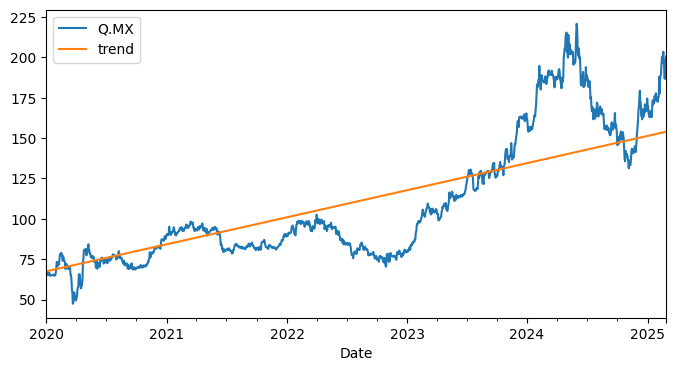

In [26]:
#Revisión después de la pandemia
df_Q_close[["Q.MX", "trend"]]["2020-01-01":].plot(figsize=(8,4))
plt.show()

# Función de Autocorrelación (ACF)
La **ACF** es una herramienta gráfica que muestra la autocorrelación de una serie de tiempo en diferentes lags (k). Se usa para identificar patrones estacionales o dependencias temporales.

## Uso de la ACF
* Identificar estacionalidad: Picos significativos en lags específicos (por ejemplo, lag 12 en datos mensuales) indican estacionalidad.

* Determinar el orden $q$ en modelos MA: La ACF ayuda a identificar el número de términos de media móvil (MA) en modelos ARIMA.

### Repaso

#### Fórmula de la Correlación
La correlación es una medida estadística que describe la relación lineal entre dos variables

La correlación entre dos variables $X$ e $Y$ se calcula como:
$$
\rho_{X,Y} = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$
Donde:
- $\text{Cov}(X, Y)$: Covarianza entre $X$ e $Y$.
- $\sigma_X$: Desviación estándar de $X$.
- $\sigma_Y$: Desviación estándar de $Y$.

**Interpretación**
* Correlación positiva: Cuando $X$ aumenta, $Y$ tiende a aumentar.

* Correlación negativa: Cuando $X$ aumenta, $Y$ tiende a disminuir.

* Correlación cercana a 0: No hay relación lineal entre $X$ e $Y$.

---

#### Fórmula de la Autocorrelación

La autocorrelación en el lag $k$ se calcula como:
$$
\rho_k = \frac{\text{Cov}(Y_t, Y_{t+k})}{\sigma_{Y_t} \sigma_{Y_{t+k}}}
$$
Donde:
- $\text{Cov}(Y_t, Y_{t+k})$: Covarianza entre $Y_t$ e $Y_{t+k}$.
- $\sigma_{Y_t}$: Desviación estándar de $Y_t$.
- $\sigma_{Y_{t+k}}$: Desviación estándar de $Y_{t+k}$.


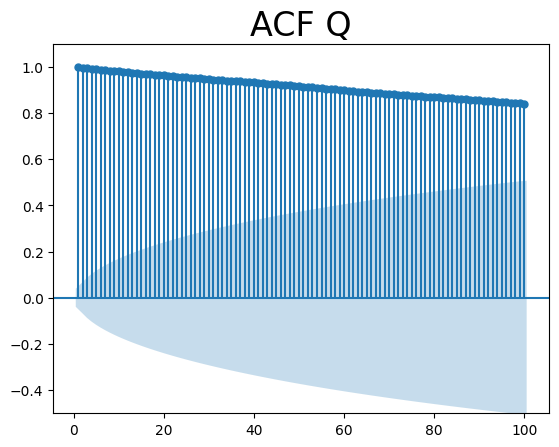

In [27]:
sgt.plot_acf(df_Q_close["Q.MX"], lags=100, zero= False)
plt.title("ACF Q", size= 24)
# Ajustar el límite del eje y
plt.ylim(-0.5, 1.10)  # Ajusta estos valores según tus datos
plt.show()

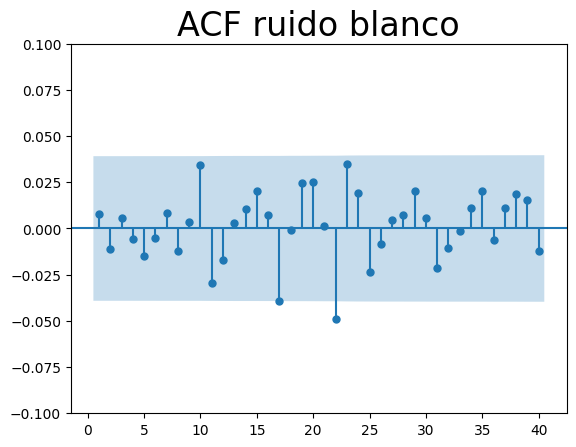

In [28]:
sgt.plot_acf(df_Q_close["wn"], lags=40, zero= False)
plt.title("ACF ruido blanco", size= 24)
# Ajustar el límite del eje y
plt.ylim(-0.10, 0.10)  # Ajusta estos valores según tus datos
plt.show()

**Nota:** todos los valores que caen en la región azul no son significativos para nuestro modelo.

# PACF (Función de Autocorrelación Parcial)

### Definición
La **PACF** mide la correlación entre los valores de una serie de tiempo y sus valores pasados, **eliminando la influencia de los lags intermedios**. Es decir, mide la correlación "pura" entre $Y_t$ y $Y_{t-k}$, sin considerar los lags $Y_{t-1}, Y_{t-2}, \dots, Y_{t-k+1}$.

---

### Fórmula de la PACF
La PACF en el lag $k$ se calcula como el coeficiente de regresión de $Y_t$ sobre $Y_{t-k}$, después de eliminar la influencia de los lags intermedios. Matemáticamente, es el coeficiente $\phi_{kk}$ en la siguiente regresión:
$$
Y_t = \phi_{k1} Y_{t-1} + \phi_{k2} Y_{t-2} + \dots + \phi_{kk} Y_{t-k} + \epsilon_t
$$

---

### Interpretación
- **PACF en lag 0**: No está definida (no tiene sentido).
- **PACF en otros lags**:
  - Si $\phi_{kk}$ es cercano a 1: Hay una fuerte correlación parcial positiva en el lag $k$.
  - Si $\phi_{kk}$ es cercano a -1: Hay una fuerte correlación parcial negativa en el lag $k$.
  - Si $\phi_{kk}$ es cercano a 0: No hay correlación parcial en el lag $k$.

---

### Uso de la PACF
- **Identificar el orden $p$ en modelos AR**: La PACF ayuda a determinar el número de términos autorregresivos (AR) en modelos ARIMA.
- **Detectar dependencias directas**: La PACF muestra solo las correlaciones directas entre $Y_t$ y $Y_{t-k}$, sin la influencia de lags intermedios.


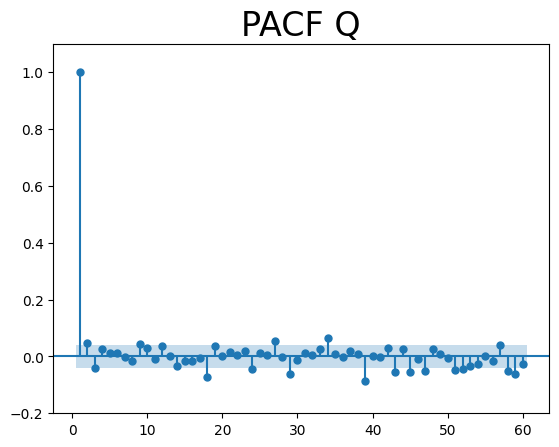

In [29]:
sgt.plot_pacf(df_Q_close["Q.MX"], zero= False, lags= 60, method= ("ols"))
plt.title("PACF Q", size= 24)
plt.ylim((-0.20, 1.10))
plt.show()

# Tecnicas de Suavizado

## SMA Simple moving average: Promedio móvil simple

**Definición:**

El Promedio Móvil Simple (SMA) es la media aritmética de los últimos $n$ valores de una serie de tiempo. Se llama "móvil" porque, a medida que llegan nuevos datos, la ventana de $n$ períodos se desplaza hacia adelante, descartando el valor más antiguo e incluyendo el más reciente.

**Formúla:**

Para una serie de tiempo $Y_t$, el SMA en el tiempo $t$ se calcula como:  
$$
\text{SMA}_t = \frac{Y_{t} + Y_{t-1} + Y_{t-2} + \dots + Y_{t-n+1}}{n}
$$

**Donde**:
- $n$: Tamaño de la ventana (número de períodos considerados).
- $Y_{t-k}$: Valor de la serie en el período $t-k$.


In [30]:
df_Q_close["mensual Q"]= df_Q_close["Q.MX"].rolling(window= 20).mean()
df_Q_close["semestral Q"]= df_Q_close["Q.MX"].rolling(window= 120).mean()

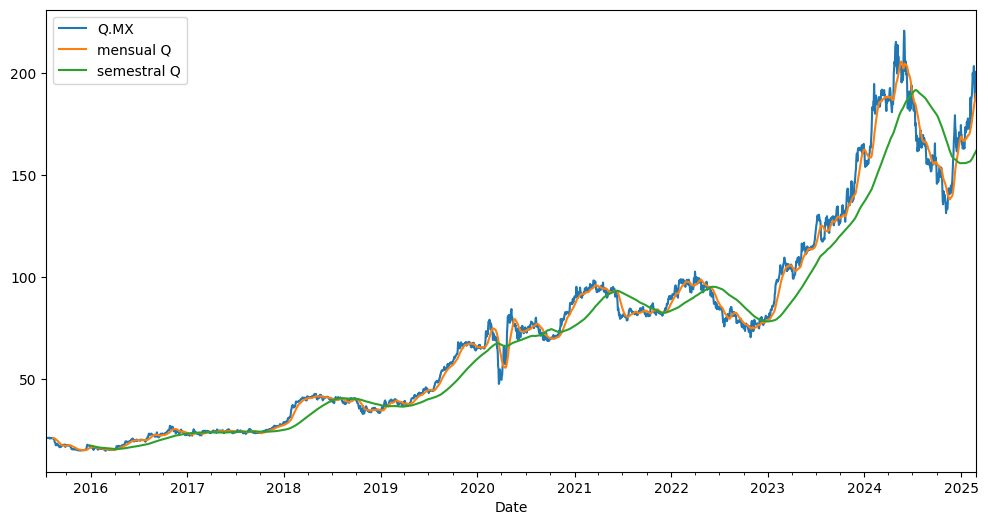

In [31]:
df_Q_close[["Q.MX", "mensual Q", "semestral Q"]].plot(figsize=(12,6))
plt.show()

## EWMA Exponentially Weighted Moving Average: Promedio móvil ponderado exponencialmente

### Fórmula
Para una serie de tiempo $Y_t$, el EWMA en el tiempo $t$ se calcula como:  
$$
\text{EWMA}_t = \alpha \cdot Y_t + (1 - \alpha) \cdot \text{EWMA}_{t-1}
$$

**Donde**:
- $\alpha$: Factor de suavizado ($0 < \alpha \leq 1$).  
- $\text{EWMA}_{t-1}$: Valor del EWMA en el período anterior.

### Pesos Exponenciales
Los pesos asignados a los datos anteriores decrecen exponencialmente:  
- Peso del dato actual ($Y_t$): $\alpha$,
- Peso del dato en $t-1$: $\alpha(1-\alpha)$,
- Peso del dato en $t-k$: $\alpha(1-\alpha)^k$.

### Parámetro adjust en Pandas
El parámetro adjust determina si los pesos se ajustan para compensar el hecho de que, en las primeras observaciones, la suma de los pesos no sea 1. Esto afecta cómo se calcula el EWMA en los inicios de la serie.

## Caso 1: `adjust=False`

### Fórmula Recursiva
$$
\text{EWMA}_t = \alpha \cdot Y_t + (1 - \alpha) \cdot \text{EWMA}_{t-1}
$$

## Caso 2: `adjust=True`

### Fórmula Ajustada
$$
\text{EWMA}_t = \frac{\sum_{k=0}^t \alpha (1 - \alpha)^k Y_{t-k}}{1 - (1 - \alpha)^{t+1}}
$$

**Conclusión:**

* adjust=False: Fórmula recursiva clásica, útil para series largas.

* adjust=True: Ajusta los pesos para evitar sesgos iniciales, útil para series cortas o donde la precisión es crítica.

El parámetro $α$ (alfa) puede definirse de tres maneras alternativas, dependiendo de cómo se quiera interpretar la "persistencia" o "decaimiento" de los pesos asignados a los datos pasados. Estas tres formas son: Span, Center of Mass y Half-life. 

| **Parámetro**      | **Símbolo** | **Fórmula para $\alpha$**         | **¿Por qué son útiles?**       |
|--------------------|-------------|-----------------------------------|-----------------------------------------------|
| Span               | $N$         | $\alpha = \frac{2}{N + 1}$       | Ideal para usuarios que piensan en "ventanas de tiempo" (ej.: traders que usan EMA de 20 días).      |
| Center of Mass     | $C$         | $\alpha = \frac{1}{C + 1}$       |  Útil en optimización, donde se busca balancear precisión y estabilidad.               |
| Half-life          | $H$         | $\alpha = 1 - 0.5^{1/H}$         | Ideal para modelar fenómenos con decaimiento exponencial (ej: volatilidad en modelos GARCH)       |

### ¿Cuándo usar cada uno?
* Span: Si quieres una interpretación similar a un promedio móvil simple pero con decaimiento exponencial.

* Center of Mass: Si buscas un equilibrio específico entre datos recientes y pasados.

* Half-life: Si modelas procesos con decaimiento exponencial (ej: volatilidad, desintegración radioactiva).

In [32]:
df_Q_close["EWMA mensual Q"]= df_Q_close["Q.MX"].ewm(span= 20, adjust= False).mean()
df_Q_close["EWMA semestral Q"]= df_Q_close["Q.MX"].ewm(span= 120, adjust= False).mean()


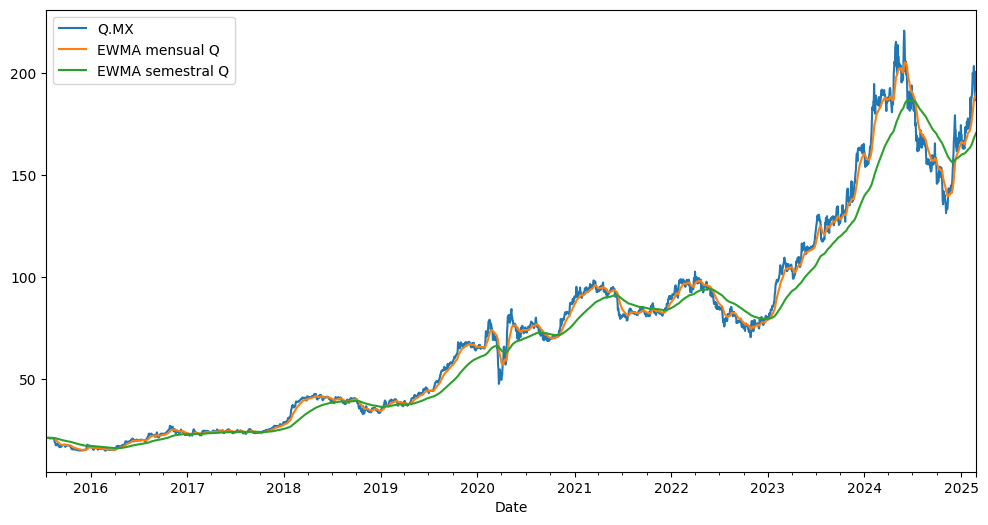

In [33]:
df_Q_close[["Q.MX", "EWMA mensual Q", "EWMA semestral Q"]].plot(figsize=(12,6))
plt.show()

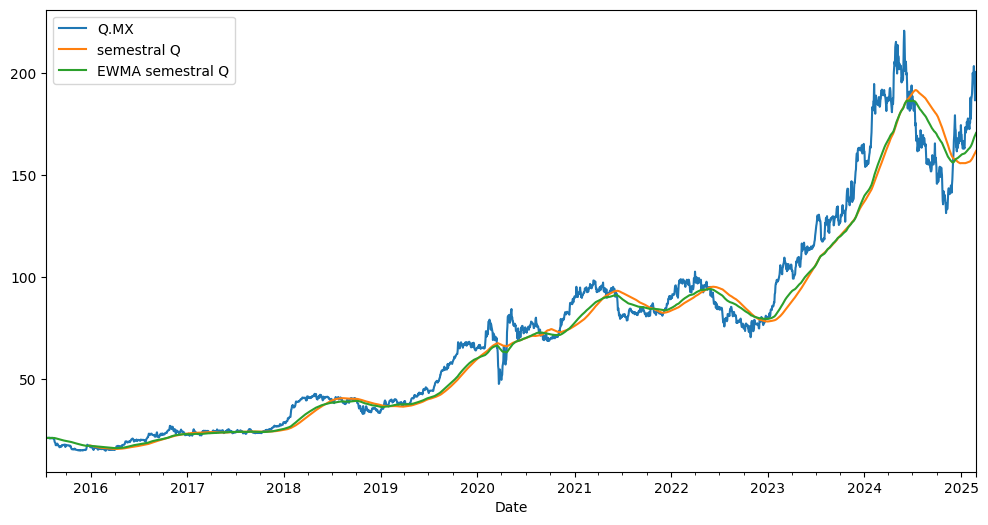

In [34]:
df_Q_close[["Q.MX", "semestral Q", "EWMA semestral Q"]].plot(figsize=(12,6))
plt.show()

#### Suavizado exponencial simple (usando SimpleExpSmoothing)

In [35]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span= 120 # Semestre a días hábiles
alpha= 2/(span +1)

df_Q_close["EWMA 6 meses"]= df_Q_close["Q.MX"].ewm(alpha= alpha, adjust= False).mean()
df_Q_close["SE 6 meses"] = SimpleExpSmoothing( df_Q_close["Q.MX"]).fit(smoothing_level= alpha, optimized= False).fittedvalues.shift(-1)

display(df_Q_close.head())

,Q.MX,wn,trend,mensual Q,semestral Q,EWMA mensual Q,EWMA semestral Q,EWMA 6 meses,SE 6 meses
Date,,,,,,,,,
2015-07-17,20.953247,151.930862,-6.486509,NaN,NaN,20.953247,20.953247,20.953247,20.953247
2015-07-20,20.915588,3.692778,-6.423013,NaN,NaN,20.949661,20.952625,20.952625,20.952625
2015-07-21,20.870396,141.194921,-6.359518,NaN,NaN,20.942111,20.951265,20.951265,20.951265
2015-07-22,20.953247,-35.290687,-6.296022,NaN,NaN,20.943172,20.951298,20.951298,20.951298
2015-07-23,20.923119,5.886043,-6.232526,NaN,NaN,20.941262,20.950832,20.950832,20.950832


**En conclusión:** 

Es igual usando ewm o SimpleExpSmoothing para el suavizado exponencial simple

## Suavizado Exponencial Doble

#### 1. Definición y Objetivo
El método Holt introduce dos ecuaciones de suavizado:

* Una para el **nivel** (ajusta el valor promedio de la serie).

* Otra para la **tendencia** (captura la dirección y magnitud del cambio a lo largo del tiempo).

Es ideal para series con **tendencia lineal** pero **sin patrones estacionales**, como ventas con crecimiento constante o demanda que aumenta gradualmente.

### **2. Ecuaciones del Método Holt**  
El método utiliza dos parámetros de suavizado:  
- **$\alpha$**: Controla el peso de las observaciones recientes en el nivel.  
- **$\beta$**: Controla el peso de las tendencias recientes en la tendencia.  

**Ecuaciones:**  

1. **Nivel suavizado ($L_t$):**  
   $$  
   L_t = \alpha \cdot y_t + (1 - \alpha) \cdot (L_{t-1} + T_{t-1})  
   $$  
   *Interpretación*: Combina la observación actual ($y_t$) con el pronóstico anterior ajustado por la tendencia pasada.  

2. **Tendencia suavizada ($T_t$):**  
   $$  
   T_t = \beta \cdot (L_t - L_{t-1}) + (1 - \beta) \cdot T_{t-1}  
   $$  
   *Interpretación*: Actualiza la tendencia basándose en el cambio del nivel actual ($L_t - L_{t-1}$) y la tendencia histórica.  

3. **Pronóstico ($\hat{y}_{t+k}$):**  
   $$  
   \hat{y}_{t+k} = L_t + k \cdot T_t  
   $$  
   *Interpretación*: Proyecta $k$ períodos futuros sumando la tendencia acumulada al nivel actual. 

| **Símbolo** | **Definición**                                                                 |  
|-------------|-------------------------------------------------------------------------------|  
| $y_t$       | Observación real en el período $t$.                                           |  
| $L_t$       | Nivel suavizado en el período $t$.                                            |  
| $T_t$       | Tendencia suavizada en el período $t$.                                        |  
| $\alpha$    | Parámetro de suavizado del nivel ($0 \leq \alpha \leq 1$).                    |  
| $\beta$     | Parámetro de suavizado de la tendencia ($0 \leq \beta \leq 1$).               |  
| $k$         | Número de períodos futuros a pronosticar.                                     |  

---
### **3. ¿Cuándo se aplica?**  
El método Holt es ideal para series de tiempo que cumplen las siguientes condiciones:  
1. **Presencia de tendencia**:  
   - La serie muestra un crecimiento o decrecimiento sostenido (ej: $y_t = a + b \cdot t + \epsilon_t$).  
   - *Ejemplos*: Ventas con aumento mensual del 5%, demanda con tendencia lineal.  
2. **Ausencia de estacionalidad**:  
   - No hay patrones cíclicos repetitivos (ej: no hay picos cada 12 meses).  
3. **Pronósticos a corto/medio plazo**:  
   - Horizonte temporal limitado (ej: $k = 1, 2, 3$ períodos futuros).  
4. **Datos no estacionarios**:  
   - La media de la serie cambia con el tiempo (ej: $\mu_t \neq \mu_{t-1}$).  

---

### **4. Pasos para Usar el Método Holt**  

1. **Inicializar componentes**:  
   - **Nivel inicial ($L_1$)**:  
     - Opción 1: $L_1 = y_1$ (primer valor de la serie).  
     - Opción 2: $L_1 = \frac{1}{n} \sum_{i=1}^{n} y_i$ (promedio de los primeros $n$ valores).  
   - **Tendencia inicial ($T_1$)**:  
     - Opción 1: $T_1 = y_2 - y_1$ (diferencia entre los dos primeros valores).  
     - Opción 2: $T_1 = \frac{y_{m} - y_1}{m - 1}$ (pendiente de una regresión lineal simple).  

2. **Seleccionar parámetros $\alpha$ y $\beta$**:  
   - Valores típicos: $\alpha \in [0.1, 0.3]$, $\beta \in [0.01, 0.1]$.  
   - Optimización: Minimizar el Error Cuadrático Medio (MSE):  
     $$  
     \text{MSE} = \frac{1}{N} \sum_{t=1}^{N} (y_t - \hat{y}_t)^2  
     $$  

3. **Calcular nivel y tendencia recursivamente**:  
   Para cada $t \geq 2$:  
   - Actualizar nivel:  
     $$  
     L_t = \alpha \cdot y_t + (1 - \alpha) \cdot (L_{t-1} + T_{t-1})  
     $$  
   - Actualizar tendencia:  
     $$  
     T_t = \beta \cdot (L_t - L_{t-1}) + (1 - \beta) \cdot T_{t-1}  
     $$  

4. **Generar pronósticos**:  
   Para $k$ períodos futuros:  
   $$  
   \hat{y}_{t+k} = L_t + k \cdot T_t  
   $$  



Tambien podemos aboradar diferentes tipo de cambio (creciente/decreciente) en la tendencia. Si una serie temporal muestra una tendencia inclinada en linea recta, se usaría un ajuste **aditivo**: Si la serie muestra una tendencia exponencial (curva), se usaría un ajuste **multiplicativo**

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df_Q_close["DESadd6"]= ExponentialSmoothing(df_Q_close["Q.MX"], trend= "add").fit().fittedvalues.shift(-1)
display(df_Q_close.head())

,Q.MX,wn,trend,mensual Q,semestral Q,EWMA mensual Q,EWMA semestral Q,EWMA 6 meses,SE 6 meses,DESadd6
Date,,,,,,,,,,
2015-07-17,20.953247,151.930862,-6.486509,NaN,NaN,20.953247,20.953247,20.953247,20.953247,21.024590
2015-07-20,20.915588,3.692778,-6.423013,NaN,NaN,20.949661,20.952625,20.952625,20.952625,20.991686
2015-07-21,20.870396,141.194921,-6.359518,NaN,NaN,20.942111,20.951265,20.951265,20.951265,20.947007
2015-07-22,20.953247,-35.290687,-6.296022,NaN,NaN,20.943172,20.951298,20.951298,20.951298,21.024528
2015-07-23,20.923119,5.886043,-6.232526,NaN,NaN,20.941262,20.950832,20.950832,20.950832,20.998899


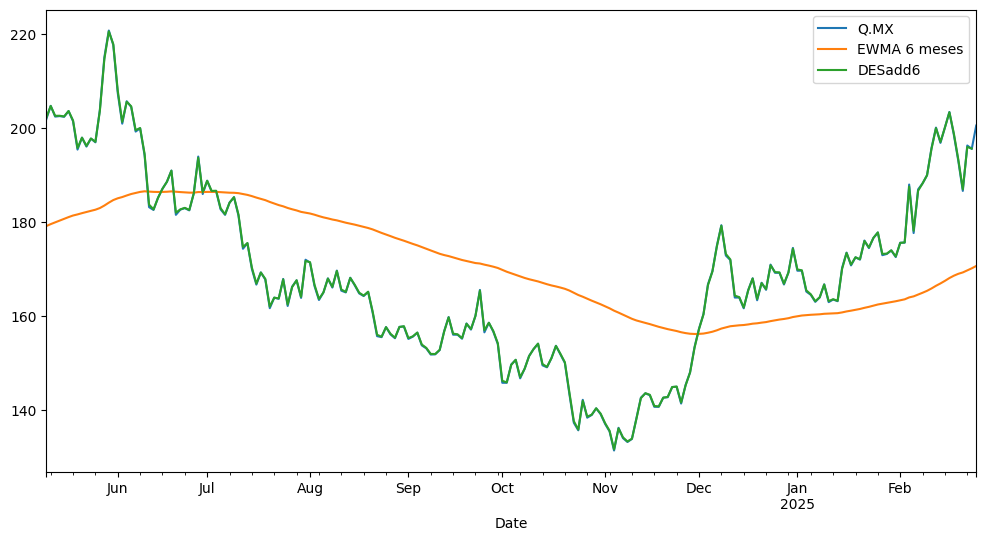

In [37]:
df_Q_close[["Q.MX", "EWMA 6 meses", "DESadd6"]].iloc[2300:].plot(figsize=(12, 6)).autoscale(axis="x", tight= True)
plt.show()

**Nota:**

Se ajusta muy bien DESadd6 a los valores reales con el metodo aditivo


# Modelo Auteregresivo AR

### 📈 **¿Qué es un modelo AR?**  
Un modelo **autoregresivo (AR)** describe una serie temporal donde el valor actual **$X_t$** depende linealmente de sus **$p$ valores pasados** más un término de error. Su ecuación general para un **AR($p$)** es:

$$
X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + \varepsilon_t
$$

- **$X_t$**: Valor en el tiempo $t$.  
- **$c$**: Constante (puede representar una tendencia).  
- **$\phi_1, \phi_2, \ldots, \phi_p$**: Coeficientes que miden la influencia de los valores pasados.  
  - **Rango de $\phi_p$**: Para garantizar **estacionariedad**, las raíces del polinomio característico $1 - \phi_1 z - \phi_2 z^2 - \ldots - \phi_p z^p = 0$ deben caer **fuera del círculo unitario**. Por ejemplo:  
    - En **AR(1)**: $|\phi_1| < 1$.  
    - En **AR(2)**: Condiciones más complejas, pero $\phi_1 + \phi_2 < 1$, $\phi_2 - \phi_1 < 1$, y $|\phi_2| < 1$.  
- **$\varepsilon_t$**: Ruido blanco, con $\varepsilon_t \sim \text{WN}(0, \sigma^2)$.

---

### 🔍 **Supuestos clave**  
1. **Estacionariedad**:  
   - La serie debe tener media constante, varianza constante y autocovarianza independiente del tiempo.  
   - Si no es estacionaria, se aplican transformaciones (diferenciación, logaritmos).  

2. **Ruido blanco en los errores**:  
   - $\mathbb{E}[\varepsilon_t] = 0$ (media cero).  
   - $\text{Var}(\varepsilon_t) = \sigma^2$ (varianza constante).  
   - $\mathbb{E}[\varepsilon_t \varepsilon_{t-k}] = 0$ para $k \neq 0$ (no autocorrelación).  

3. **Linealidad**:  
   - Relación lineal entre $X_t$ y sus rezagos (no captura efectos no lineales).  
---
### 🛠️ **¿Cómo construir un modelo AR?**
1. **Verificar estacionariedad**: Usa pruebas como la de Dickey-Fuller o inspección visual.

2. **Determinar el orden $p:$**

    * FACP (Función de Autocorrelación Parcial): En un AR(p), la FACP tiene picos significativos hasta el rezago $p$.

    * Criterios de información: AIC o BIC (eligen el modelo con el valor más bajo).

3. Estimar coeficientes: Métodos como Mínimos Cuadrados o Máxima Verosimilitud.

4. Validar residuos: Deben comportarse como ruido blanco (prueba Ljung-Box).

In [38]:
display(df_Q_close)
print(df_Q_close.info())

,Q.MX,wn,trend,mensual Q,semestral Q,EWMA mensual Q,EWMA semestral Q,EWMA 6 meses,SE 6 meses,DESadd6
Date,,,,,,,,,,
2015-07-17,20.953247,151.930862,-6.486509,NaN,NaN,20.953247,20.953247,20.953247,20.953247,21.024590
2015-07-20,20.915588,3.692778,-6.423013,NaN,NaN,20.949661,20.952625,20.952625,20.952625,20.991686
2015-07-21,20.870396,141.194921,-6.359518,NaN,NaN,20.942111,20.951265,20.951265,20.951265,20.947007
2015-07-22,20.953247,-35.290687,-6.296022,NaN,NaN,20.943172,20.951298,20.951298,20.951298,21.024528
2015-07-23,20.923119,5.886043,-6.232526,NaN,NaN,20.941262,20.950832,20.950832,20.950832,20.998899
...,...,...,...,...,...,...,...,...,...,...
2025-02-20,193.000000,48.861011,153.693423,185.8660,160.404667,188.080681,168.981104,168.981104,168.981104,193.317018
2025-02-21,186.649994,138.131151,153.757915,186.3670,160.684333,187.944425,169.273152,169.273152,169.273152,187.000213
2025-02-24,196.330002,113.914887,153.822407,187.2945,161.055667,188.743052,169.720372,169.720372,169.720372,196.011565


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2509 entries, 2015-07-17 to 2025-02-26
Freq: B
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Q.MX              2509 non-null   float64
 1   wn                2509 non-null   float64
 2   trend             2509 non-null   float64
 3   mensual Q         2490 non-null   float64
 4   semestral Q       2390 non-null   float64
 5   EWMA mensual Q    2509 non-null   float64
 6   EWMA semestral Q  2509 non-null   float64
 7   EWMA 6 meses      2509 non-null   float64
 8   SE 6 meses        2508 non-null   float64
 9   DESadd6           2508 non-null   float64
dtypes: float64(10)
memory usage: 280.2 KB
None


In [39]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.api import SARIMAX

display(train)
print("-"*50)
display(test)


,Q.MX
Date,
2015-07-17 00:00:00-05:00,20.953247
2015-07-20 00:00:00-05:00,20.915588
2015-07-21 00:00:00-05:00,20.870396
2015-07-22 00:00:00-05:00,20.953247
2015-07-23 00:00:00-05:00,20.923119
...,...
2023-03-16 00:00:00-06:00,104.463730
2023-03-17 00:00:00-06:00,103.332848
2023-03-21 00:00:00-06:00,106.274971


--------------------------------------------------


,Q.MX
Date,
2023-03-24 00:00:00-06:00,104.546471
2023-03-27 00:00:00-06:00,103.958046
2023-03-28 00:00:00-06:00,105.272812
2023-03-29 00:00:00-06:00,104.757942
2023-03-30 00:00:00-06:00,106.072701
...,...
2025-02-20 00:00:00-06:00,193.000000
2025-02-21 00:00:00-06:00,186.649994
2025-02-24 00:00:00-06:00,196.330002


## Modelo AR(1)

In [40]:
#Usando el modelo AutoReg
model_ar = AutoReg(df_Q_close["Q.MX"], lags= 1)
results_ar = model_ar.fit()
print(results_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                   Q.MX   No. Observations:                 2509
Model:                     AutoReg(1)   Log Likelihood               -4983.133
Method:               Conditional MLE   S.D. of innovations              1.765
Date:                Fri, 21 Mar 2025   AIC                           9972.265
Time:                        20:25:04   BIC                           9989.747
Sample:                    07-20-2015   HQIC                          9978.611
                         - 02-26-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0386      0.063      0.615      0.538      -0.084       0.162
Q.MX.L1        1.0004      0.001   1414.143      0.000       0.999       1.002
                                    Roots           

In [41]:
#usando el modelo ARIMA para lag 1

model= SARIMAX(df_Q_close["Q.MX"], order= (1,0,0), trend= "c") #Falta de constante: Si la serie tiene una tendencia, debes incluir trend='c'.
results_ar_1= model.fit()
print(results_ar_1.summary())

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   Q.MX   No. Observations:                 2509
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4991.108
Date:                Fri, 21 Mar 2025   AIC                           9988.217
Time:                        20:25:05   BIC                          10005.700
Sample:                    07-17-2015   HQIC                          9994.563
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0253      0.062      0.405      0.685      -0.097       0.148
ar.L1          0.9998      0.001   1839.458      0.000       0.999       1.001
sigma2         3.1195      0.034     90.621      0.0

| **Característica**         | **SARIMAX**                                                                 | **AutoReg**                                                                 |
|----------------------------|-----------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| **Tipo de Modelo**          | ARMA(p, q), ARIMA(p, d, q), SARIMA                                         | AR(p) puro                                                                  |
| **Ecuación General**        | $y_t = c + \phi_1 y_{t-1} + \theta_1 \epsilon_{t-1} + \epsilon_t$          | $y_t = c + \phi_1 y_{t-1} + \epsilon_t$                                     |
| **Término de Tendencia**    | Configurable: <br> `trend='c'`: $c$ (constante) <br> `trend='t'`: $\beta t$ | Constante incluida por defecto ($c$)                                        |
| **Componente MA**           | Sí ($\theta_1 \epsilon_{t-1}$)                                             | No                                                                          |
| **Integración (d)**         | Sí ($\Delta^d y_t$)                                                        | No                                                                          |
| **Variables Exógenas**      | Sí: $X_t \beta$                                                             | No                                                                          |
| **Varianza del Error**      | $\sigma^2$ estimada                                                        | No reportada                                                                |
| **Estimación**              | Máxima Verosimilitud (MLE)                                                 | Mínimos Cuadrados (OLS)                                                     |
| **Diagnósticos**            | Ljung-Box, Jarque-Bera, Heteroscedasticidad                                 | AIC, BIC, HQIC                                                              |
| **Flexibilidad Estacional** | SARIMA: $\Phi_P y_{t-P} + \Theta_Q \epsilon_{t-Q}$                         | No                                                                          |
| **Velocidad**               | Más lento (modelo complejo)                                                | Más rápido                                                                  |
| **Uso Recomendado**         | Modelos avanzados (ARMA/ARIMA con integración o variables externas)         | Modelos AR simples sin necesidad de MA o diferenciación                     |

**¿Cuál elegir?**

- Usa AutoReg si:

Solo necesitas un modelo AR simple y rápido.

No requieres términos MA, integración o variables exógenas.

- Usa SARIMAX si:

Planeas extender el modelo a ARMA, ARIMA, o incluir variables externas.

Necesitas diagnósticos avanzados o modelar la varianza del error.

## Higher-Lag AR Models

In [42]:
model_ar_2 = SARIMAX(df_Q_close["Q.MX"], order= (2,0,0), trend= "c")
results_ar_2 = model_ar_2.fit()
print(results_ar_2.summary())

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   Q.MX   No. Observations:                 2509
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -4988.769
Date:                Fri, 21 Mar 2025   AIC                           9985.538
Time:                        20:25:06   BIC                          10008.848
Sample:                    07-17-2015   HQIC                          9993.999
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0239      0.062      0.383      0.702      -0.098       0.146
ar.L1          0.9565      0.009    110.365      0.000       0.940       0.974
ar.L2          0.0432      0.009      4.971      0.0

In [43]:
model_ar_3 = SARIMAX(df_Q_close["Q.MX"], order= (3,0,0), trend= "c")
results_ar_3 = model_ar_3.fit()
print(results_ar_3.summary())

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   Q.MX   No. Observations:                 2509
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -4986.574
Date:                Fri, 21 Mar 2025   AIC                           9983.147
Time:                        20:25:08   BIC                          10012.285
Sample:                    07-17-2015   HQIC                          9993.724
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0252      0.063      0.399      0.690      -0.099       0.149
ar.L1          0.9583      0.009    109.717      0.000       0.941       0.975
ar.L2          0.0833      0.014      6.154      0.0

In [44]:
model_ar_4 = SARIMAX(df_Q_close["Q.MX"], order= (4,0,0), trend= "c")
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary())

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   Q.MX   No. Observations:                 2509
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -4985.951
Date:                Fri, 21 Mar 2025   AIC                           9983.902
Time:                        20:25:11   BIC                          10018.868
Sample:                    07-17-2015   HQIC                          9996.594
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0246      0.063      0.390      0.697      -0.099       0.148
ar.L1          0.9591      0.009    107.767      0.000       0.942       0.977
ar.L2          0.0816      0.014      6.018      0.0

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
model_ar_5 = SARIMAX(df_Q_close["Q.MX"], order= (5,0,0), trend= "c")
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   Q.MX   No. Observations:                 2509
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -4985.798
Date:                Fri, 21 Mar 2025   AIC                           9985.595
Time:                        20:25:13   BIC                          10026.389
Sample:                    07-17-2015   HQIC                         10000.402
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0242      0.064      0.381      0.703      -0.100       0.149
ar.L1          0.9589      0.009    104.961      0.000       0.941       0.977
ar.L2          0.0822      0.014      5.939      0.0

## Likelihood Ratio Test (LRT)

Se usa para saber si dos modelos son significativamente diferentes (como un contraste de hipótesis entre modelos)

**Aplicable solo si los modelos son anidados** (un modelo es una versión restringida del otro).

Ejemplo: Comparar ARMA(1,0) vs. ARMA(2,0) (el ARMA(1,0) es un caso especial del ARMA(2,0) con $ϕ_2 =0$.

In [46]:
def LLR_test(mod_simple, mod_complejo):
    """
    Realiza el Likelihood Ratio Test (LRT) entre dos modelos anidados.
    
    Args:
        mod_simple: Modelo más simple (menos parámetros).
        mod_complejo: Modelo más complejo (más parámetros, debe ser anidado).
    
    Returns:
        Tuple: (Estadístico LRT, grados de libertad, p-valor).
    """
    # Verificar si los modelos son anidados
    if not (set(mod_simple.param_names).issubset(set(mod_complejo.param_names))):
        raise ValueError("Los modelos no son anidados. LRT no aplicable.")
    
    # Calcular estadístico LRT
    L1 = mod_simple.llf  # Log-Likelihood del modelo simple
    L2 = mod_complejo.llf  # Log-Likelihood del modelo complejo
    lr_stat = 2 * (L2 - L1)
    
    # Grados de libertad (diferencia en parámetros)
    dof = mod_complejo.df_model - mod_simple.df_model
    
    # Calcular p-valor
    p_value = 1 - chi2.cdf(lr_stat, dof)
    
    return lr_stat, dof, p_value.round(4)

## Comparing Higher-Lag AR Models

In [47]:
# Lista de modelos ajustados (ejemplo)
modelos = [results_ar_1, results_ar_2, results_ar_3, results_ar_4, results_ar_5]

# Realizar LRT por pares
for i in range(len(modelos) - 1):
    mod_simple = modelos[i]
    mod_complejo = modelos[i + 1]
    
    lr_stat, dof, p_value = LLR_test(mod_simple, mod_complejo)
    
    print(f"\nComparación AR({i+1}) vs AR({i+2}):")
    print(f"Estadístico LRT: {lr_stat:.3f}")
    print(f"Grados de libertad: {dof}")
    print(f"p-valor: {p_value}")
    if p_value < 0.05:
        print("Conclusión: El modelo complejo es significativamente mejor (p < 0.05).")
    else:
        print("Conclusión: No hay mejora significativa (p >= 0.05).")



Comparación AR(1) vs AR(2):
Estadístico LRT: 4.679
Grados de libertad: 1
p-valor: 0.0305
Conclusión: El modelo complejo es significativamente mejor (p < 0.05).

Comparación AR(2) vs AR(3):
Estadístico LRT: 4.390
Grados de libertad: 1
p-valor: 0.0361
Conclusión: El modelo complejo es significativamente mejor (p < 0.05).

Comparación AR(3) vs AR(4):
Estadístico LRT: 1.245
Grados de libertad: 1
p-valor: 0.2645
Conclusión: No hay mejora significativa (p >= 0.05).

Comparación AR(4) vs AR(5):
Estadístico LRT: 0.307
Grados de libertad: 1
p-valor: 0.5794
Conclusión: No hay mejora significativa (p >= 0.05).


**Conclusión:**

El mejor modelo es AR(3) y como el coeficiente es significativamente distinto de cero para dicho modelo, será nuestra elección final.

* Para mayor información ver la parte 57.Python Ar(p) Precios

In [48]:
print(LLR_test(results_ar_1, results_ar_3))

(9.069633308045013, 2, 0.0107)


Como el último elemento es el p-valor y es menor de 0.05 entonces es mejor usar el modelo results_ar_3.

## Análisis de Residuos

In [49]:
df_Q_close["res_price"]= results_ar_3.resid

In [50]:
sts.adfuller(df_Q_close["res_price"])

(-67.87274899843544,
 0.0,
 0,
 2508,
 {'1%': -3.432960050084045,
  '5%': -2.8626931078801285,
  '10%': -2.567383843706519},
 9880.498818259322)

Por lo anterior, el p-valor es cero, se rechaza la hipótesis que no son estacionarios, es decir son estacionarios.

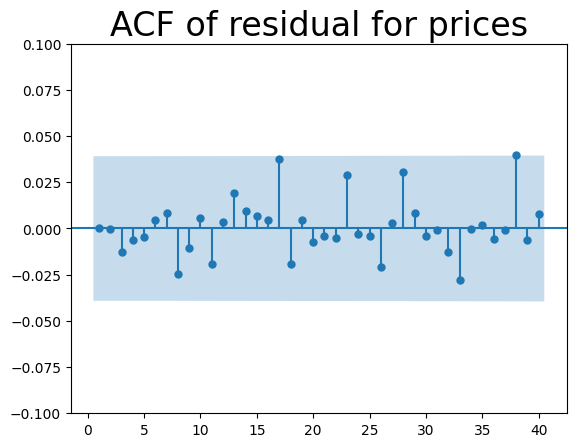

In [51]:
sgt.plot_acf(df_Q_close["res_price"], zero=False, lags=40)
plt.title("ACF of residual for prices", size=24)
plt.ylim((-0.10, 0.10))
plt.show()

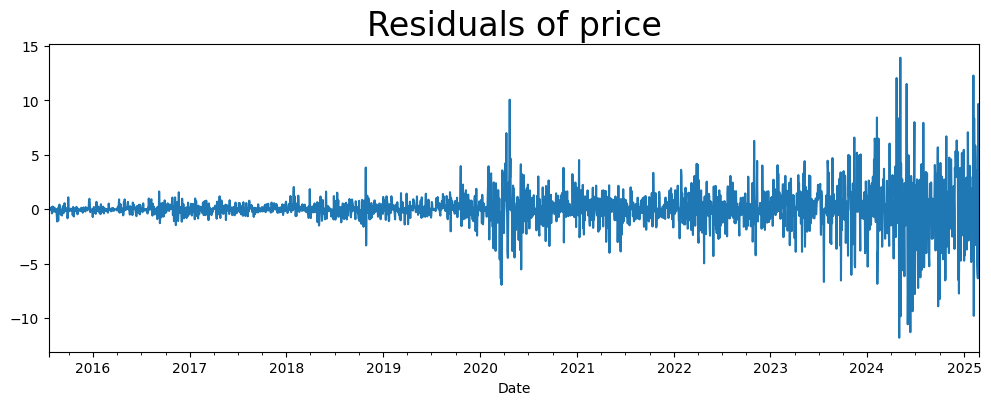

In [52]:
df_Q_close["res_price"][1:].plot(figsize= (12, 4))
plt.title("Residuals of price", size=24)
plt.show()

## Análisis de Rendimientos o Retornos de Q (diarios)

In [53]:
# Test de DF para ver si la serie es estacionaria o no
sts.adfuller(df_Q_close["Q.MX"])

(0.6444333325471279,
 0.9886611373812665,
 2,
 2506,
 {'1%': -3.432962135264372,
  '5%': -2.862694028699462,
  '10%': -2.567384333962417},
 9883.622754349883)

Como el p-valor es 0.9886611373812665 este es mayor de 5% significa que la serie es **no estacionaria.**

In [54]:
df_Q_close["returns"] = df_Q_close["Q.MX"].pct_change(1).mul(100)
df_Q_close = df_Q_close[1:] # esto es para quitar el valor nulo del primer dato del retorno

In [55]:
sts.adfuller(df_Q_close["returns"])

(-26.1981344655911,
 0.0,
 3,
 2504,
 {'1%': -3.4329642237790847,
  '5%': -2.862694950990622,
  '10%': -2.5673848250020415},
 10110.023031198492)

El p-valor el 0 por lo que la serie es estacionaria.

## ACF y PACF for returns

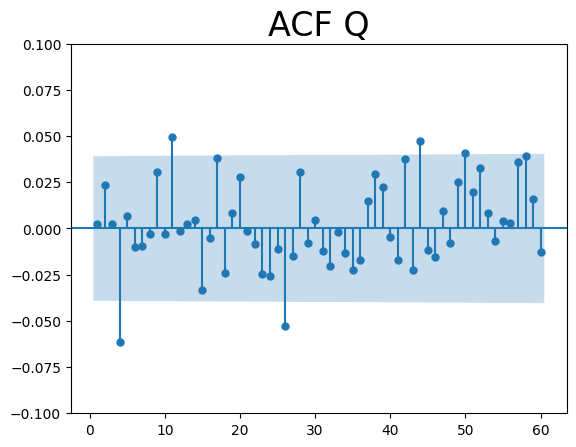

In [56]:
sgt.plot_acf(df_Q_close["returns"], lags=60, zero= False)
plt.title("ACF Q", size= 24)
# Ajustar el límite del eje y
plt.ylim(-0.1, 0.1)  # Ajusta estos valores según tus datos
plt.show()

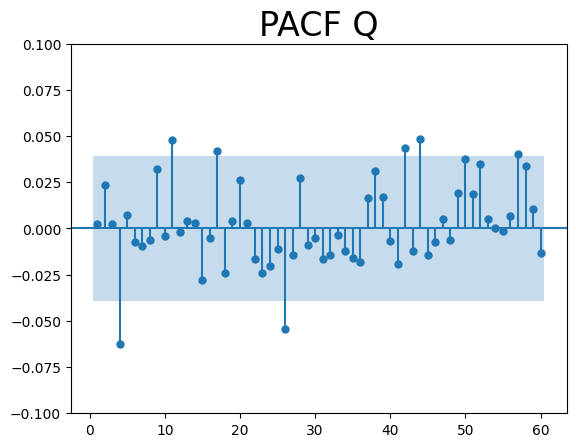

In [57]:
sgt.plot_pacf(df_Q_close["returns"], zero= False, lags= 60, method= ("ols"))
plt.title("PACF Q", size= 24)
plt.ylim((-0.10, 0.10))
plt.show()

## AR(n) for Returns

In [58]:
# Función para crear modelos AR y almacenar sus resultados
def crear_ar(df, n):
    resultados = []
    for i in range(1, n+1):  # Itera de 1 a n (incluyendo n)
        modelo = SARIMAX(df, order=(i, 0, 0), trend='c')
        resultados.append(modelo.fit(disp=0))  # Almacena el modelo ajustado
        print(f"Resumen AR({i}):")
        print(resultados[-1].summary())  # Imprime el último modelo ajustado
    return resultados

In [59]:
# Crear modelos AR(1) a AR(5)
rend_resultados_ar = crear_ar(df_Q_close["returns"], n=5)

Resumen AR(1):
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 2508
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -5112.211
Date:                Fri, 21 Mar 2025   AIC                          10230.422
Time:                        20:25:15   BIC                          10247.904
Sample:                    07-20-2015   HQIC                         10236.768
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1071      0.038      2.846      0.004       0.033       0.181
ar.L1          0.0023      0.013      0.177      0.859      -0.023       0.028
sigma2         3.4516      0.050     

In [60]:
# Paso 2: Comparar modelos
print("\n=== Resultados del LRT ===")
for i in range(4):  # Comparaciones: 0-1, 1-2, 2-3, 3-4
    mod_simple = rend_resultados_ar[i]
    mod_complejo = rend_resultados_ar[i+1]
    lr_stat, dof, p_valor = LLR_test(mod_simple, mod_complejo)
    print(f"AR({i+1}) vs AR({i+2}): p-valor = {p_valor:.4f}")


=== Resultados del LRT ===
AR(1) vs AR(2): p-valor = 0.2434
AR(2) vs AR(3): p-valor = 0.9045
AR(3) vs AR(4): p-valor = 0.0019
AR(4) vs AR(5): p-valor = 0.7195


In [61]:
print(LLR_test(rend_resultados_ar[0], rend_resultados_ar[3]))

(11.05532501387097, 3, 0.0114)


## Automatización del mejor modelo AR(n) para Returns de Q

La serie debe ser estacionaria para que el modelo funcione

In [62]:
def best_ar_model(data, test_size=0.2, plot=True):
    """
    Encuentra el mejor modelo AR(n) según AIC/BIC y grafica predicciones.
    
    Args:
        data (pd.Series): Serie temporal.
        max_lag (int): Máximo número de retardos a evaluar.
        test_size (float): Proporción de datos para test (0.0-1.0).
        plot (bool): Si True, grafica predicciones.
        
    Returns:
        best_model: Mejor modelo SARIMAXResults.
        best_lag (int): Lag óptimo.
        results_df (pd.DataFrame): Resultados de todos los modelos.
    """
    # Dividir en train y test
    train_size = int(len(data) * (1 - test_size))
    train, test = data.iloc[:train_size], data.iloc[train_size:]
    
    # Calcular max_lag basado en la longitud de train (Schwert (1989))
    max_lag = min(40, int(12 * (len(train)/100)**(1/4)))  # Fórmula recomendada para series financieras
    print(f'Retraso máximo calculado: {max_lag}')
    
    # Evaluar modelos AR(1) a AR(max_lag)
    results = []
    for lag in range(1, max_lag + 1):
        try:
            # Ajustar modelo AR(lag)
            model = SARIMAX(train, order=(lag, 0, 0), trend='c')
            results_fit = model.fit(disp=0)
            
            # Predecir en test
            forecast = results_fit.get_forecast(steps=len(test))
            pred = forecast.predicted_mean
            rmse = np.sqrt(mean_squared_error(test, pred))
            
            # Almacenar resultados
            results.append({
                'Lag': lag,
                'AIC': results_fit.aic,
                'BIC': results_fit.bic,
                'RMSE': rmse
            })
        except:
            continue
    
    # DataFrame con resultados
    results_df = pd.DataFrame(results).set_index('Lag')
    
    # Seleccionar mejor modelo por AIC
    best_lag = results_df['AIC'].idxmin()
    best_model = SARIMAX(data, order=(best_lag, 0, 0), trend='c').fit(disp=0)
    
    # Graficar PREDICCIONES solo en el período de TEST
    if plot:
        forecast = best_model.get_forecast(steps=len(test))
        pred = forecast.predicted_mean
        ci = forecast.conf_int()
        
        plt.figure(figsize=(12, 6))
        # Graficar solo datos de TEST y predicciones
        plt.plot(test.index, test, label='Real (Test)', color='blue')
        plt.plot(test.index, pred, label=f'Predicción AR({best_lag})', color='red')
        plt.fill_between(test.index, ci.iloc[:,0], ci.iloc[:,1], color='pink', alpha=0.3)
        
        # Ajustar límites del eje X al rango de TEST
        plt.xlim(test.index.min(), test.index.max())
        
        plt.title(f'Mejor Modelo: AR({best_lag}) | AIC: {results_df.loc[best_lag, "AIC"]:.2f}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return best_model, best_lag, results_df

# Uso del ejemplo
#best_model, best_lag, results_df = best_ar_model(df_Q_close["Q.MX"], max_lag=10)
#print(f"\nMejor modelo: AR({best_lag})")
#print(results_df.sort_values('AIC'))


Retraso máximo calculado: 25


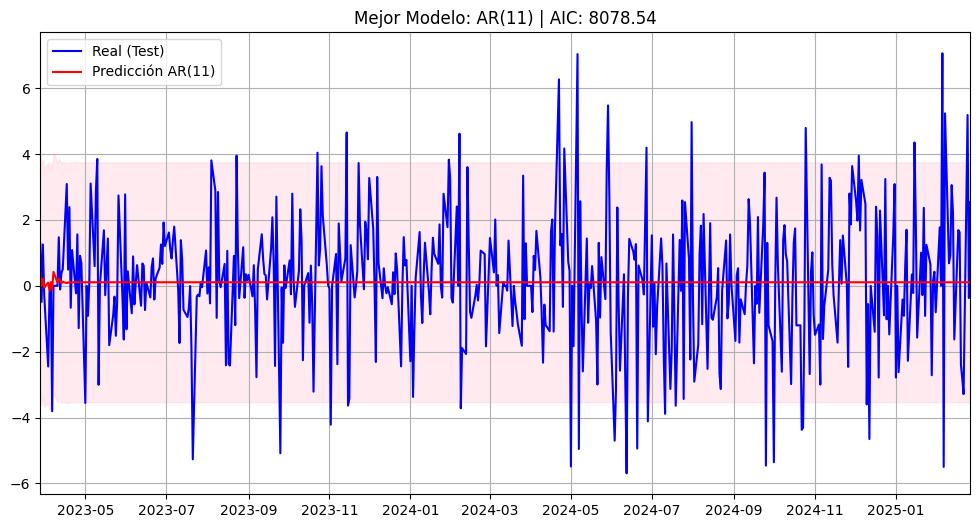


Mejor modelo: AR(11)
             AIC          BIC      RMSE
Lag                                    
11   8078.542951  8151.393625  2.002888
12   8080.315053  8158.769625  2.002877
13   8082.265260  8166.323729  2.002859
15   8082.785701  8178.051967  2.002737
14   8084.235299  8173.897666  2.002881
16   8084.541407  8185.411570  2.002931
17   8084.849514  8191.323575  2.003128
18   8085.513470  8197.591429  2.003128
20   8086.996229  8210.281984  2.002960
19   8087.513166  8205.195023  2.003134
21   8088.940565  8217.830218  2.002992
23   8090.747168  8230.844617  2.002636
22   8090.811450  8225.305001  2.003050
4    8091.233729  8124.857117  2.002896
9    8091.332740  8152.975618  2.002970
24   8091.947910  8237.649257  2.002532
5    8092.561462  8131.788748  2.002846
10   8093.157106  8160.403881  2.002960
25   8093.297129  8244.602375  2.002238
6    8094.379265  8139.210449  2.002878
7    8095.662060  8146.097142  2.002808
8    8097.294900  8153.333880  2.002645
1    8100.155091  

In [63]:
best_model, best_lag, results_df = best_ar_model(df_Q_close["returns"])
print(f"\nMejor modelo: AR({best_lag})")
print(results_df.sort_values('AIC'))


## Modelos de Medias Móviles MA(n) para returns de Q

In [64]:
# Función para crear modelos MA y almacenar sus resultados
def crear_ma(df, n):
    resultados_ma = []
    for i in range(1, n+1):  # Itera de 1 a n (incluyendo n)
        modelo = SARIMAX(df, order=(0, 0, i), trend='c')
        resultados_ma.append(modelo.fit(disp=0))  # Almacena el modelo ajustado
        print(f"Resumen MA({i}):")
        print(resultados_ma[-1].summary())  # Imprime el último modelo ajustado
    return resultados_ma

In [65]:
resultados_ma= crear_ma(df_Q_close["returns"], 12)

Resumen MA(1):
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 2508
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -5112.211
Date:                Fri, 21 Mar 2025   AIC                          10230.423
Time:                        20:26:05   BIC                          10247.905
Sample:                    07-20-2015   HQIC                         10236.769
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1073      0.038      2.855      0.004       0.034       0.181
ma.L1          0.0022      0.013      0.165      0.869      -0.024       0.028
sigma2         3.4516      0.050     

In [66]:
# Paso 2: Comparar modelos
print("\n=== Resultados del LRT ===")
for i in range(11):  # Comparaciones: 0-1, 1-2, 2-3, 3-4
    mod_simple = resultados_ma[i]
    mod_complejo = resultados_ma[i+1]
    lr_stat, dof, p_valor = LLR_test(mod_simple, mod_complejo)
    print(f"MA({i+1}) vs MA({i+2}): p-valor = {p_valor:.4f}")


=== Resultados del LRT ===
MA(1) vs MA(2): p-valor = 0.2130
MA(2) vs MA(3): p-valor = 0.9035
MA(3) vs MA(4): p-valor = 0.0021
MA(4) vs MA(5): p-valor = 0.5793
MA(5) vs MA(6): p-valor = 0.5611
MA(6) vs MA(7): p-valor = 0.8205
MA(7) vs MA(8): p-valor = 0.8429
MA(8) vs MA(9): p-valor = 0.1348
MA(9) vs MA(10): p-valor = 0.9105
MA(10) vs MA(11): p-valor = 0.0232
MA(11) vs MA(12): p-valor = 0.9957


In [67]:
print(LLR_test(resultados_ma[3], resultados_ma[10]))

(8.139883611285768, 7, 0.3204)


In [68]:
resultados_ma[10].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 2508
Model:              SARIMAX(0, 0, 11)   Log Likelihood               -5102.634
Date:                Fri, 21 Mar 2025   AIC                          10231.268
Time:                        20:26:14   BIC                          10307.022
Sample:                    07-20-2015   HQIC                         10258.766
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1073      0.039      2.754      0.006       0.031       0.184
ma.L1          0.0034      0.014      0.242      0.809      -0.024       0.031
ma.L2          0.0219      0.014      1.535      0.125      -0.006       0.050
ma.L3          0.0026      0.015      0.169      0.866      -0.027       0.033
ma.L4         -0.0597      0.015     -3.854      0.000      -0.090      -0.029
ma.L5          0.0093      0.018      0.528      0.598      -0.025       0.044
ma.L6         -0.0126      0.016     -0.769      0.442      -0.045       0.020
ma.L7         -0.0047      0.016     -0.285      0.775      -0.037       0.027
ma.L8         -0.0062      0.017     -0.371      0.711      -0.039       0.026
ma.L9          0.0292      0.015      1.999      0.046       0.001       0.058
ma.L10        -0.0021      0.016     -0.130      0.897      -0.034       0.029
ma.L11         0.0464      0.017      2.722      0.006       0.013       0.080
sigma2         3.4253      0.057     60.547      0.000       3.314       3.536
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3390.88
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Conclusión** El mejor modelo es MA(4)

## Modelos ARMA

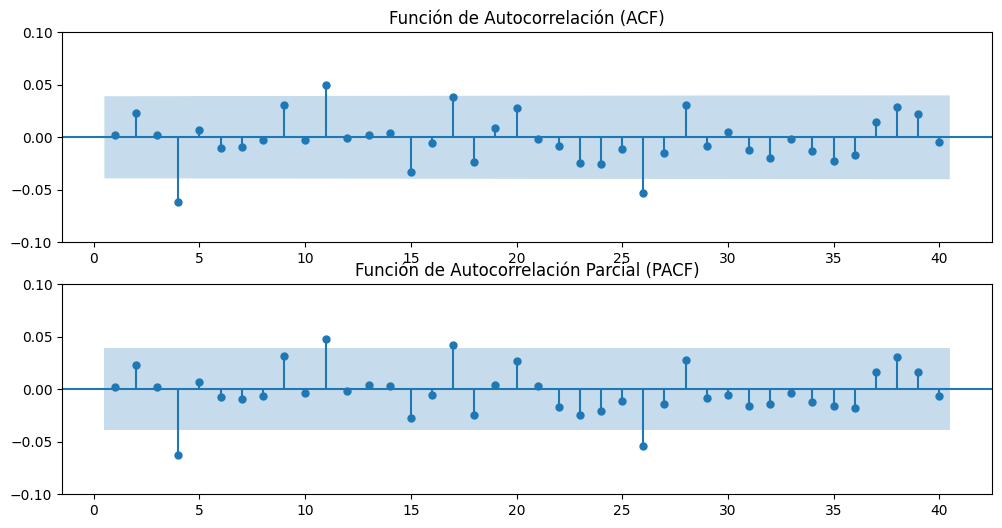

In [69]:
# Graficar ACF y PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sgt.plot_acf(df_Q_close["returns"], zero=False, lags=40, ax=ax[0])
ax[0].set_ylim(-0.1, 0.1)  # Ajustar límites del eje Y
ax[0].set_title("Función de Autocorrelación (ACF)")

sgt.plot_pacf(df_Q_close["returns"], zero=False, lags=40, ax=ax[1], method='ols')
ax[1].set_ylim((-0.1, 0.1))
ax[1].set_title("Función de Autocorrelación Parcial (PACF)")

plt.show()

In [70]:
# Definir órdenes a probar
orders = [(1,1), (2,2), (4,4), (2,1), (1,2)]

# Evaluar cada modelo
results_arma = []
for p, q in orders:
    model = SARIMAX(df_Q_close["returns"], order=(p, 0, q), trend='c')
    results_arma_fit = model.fit(disp=0)
    results_arma.append({
        "ARMA(p,q)": f"({p},{q})",
        "Estadístico LRT": results_arma_fit.llf,
        "AIC": results_arma_fit.aic,
        "BIC": results_arma_fit.bic
    })

# Mostrar resultados
results_arma_df = pd.DataFrame(results_arma)
print(results_arma_df.sort_values("AIC"))

  ARMA(p,q)  Estadístico LRT           AIC           BIC
1     (2,2)     -5107.394413  10226.788826  10261.752271
2     (4,4)     -5105.585874  10231.171748  10289.444157
0     (1,1)     -5112.144509  10232.289018  10255.597981
4     (1,2)     -5111.434774  10232.869547  10262.005752
3     (2,1)     -5111.529569  10233.059137  10262.195342


In [71]:
modelo_ret_ar_2_ma_2 = SARIMAX(df_Q_close["returns"], order=(2, 0, 2), trend='c')
results_ret_ar_2_ma_2= modelo_ret_ar_2_ma_2.fit()
results_ret_ar_2_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 2508
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -5107.394
Date:                Fri, 21 Mar 2025   AIC                          10226.789
Time:                        20:26:24   BIC                          10261.752
Sample:                    07-20-2015   HQIC                         10239.480
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2329      0.083      2.822      0.005       0.071       0.395
ar.L1         -0.2572      0.042     -6.096      0.000      -0.340      -0.175
ar.L2         -0.9132      0.040    -23.114      0.000      -0.991      -0.836
ma.L1          0.2549      0.037      6.928      0.000       0.183       0.327
ma.L2          0.9378      0.034     27.570      0.000       0.871       1.005
sigma2         3.4383      0.050     68.599      0.000       3.340       3.537
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              3778.09
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
modelo_ret_ar_2_ma_1 = SARIMAX(df_Q_close["returns"], order=(2, 0, 1), trend='c')
results_ret_ar_2_ma_1= modelo_ret_ar_2_ma_1.fit()
results_ret_ar_2_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 2508
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -5111.530
Date:                Fri, 21 Mar 2025   AIC                          10233.059
Time:                        20:26:25   BIC                          10262.195
Sample:                    07-20-2015   HQIC                         10243.635
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1026      0.074      1.389      0.165      -0.042       0.247
ar.L1          0.0217      0.621      0.035      0.972      -1.196       1.239
ar.L2          0.0233      0.014      1.706      0.088      -0.003       0.050
ma.L1         -0.0194      0.622     -0.031      0.975      -1.238       1.199
sigma2         3.4497      0.053     65.579      0.000       3.347       3.553
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3786.44
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
modelo_ret_ar_1_ma_2 = SARIMAX(df_Q_close["returns"], order=(1, 0, 2), trend='c')
results_ret_ar_1_ma_2= modelo_ret_ar_1_ma_2.fit()
results_ret_ar_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 2508
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -5111.435
Date:                Fri, 21 Mar 2025   AIC                          10232.870
Time:                        20:26:26   BIC                          10262.006
Sample:                    07-20-2015   HQIC                         10243.446
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1053      0.068      1.539      0.124      -0.029       0.239
ar.L1          0.0188      0.550      0.034      0.973      -1.059       1.096
ma.L1         -0.0166      0.550     -0.030      0.976      -1.095       1.062
ma.L2          0.0265      0.014      1.950      0.051      -0.000       0.053
sigma2         3.4495      0.053     65.414      0.000       3.346       3.553
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3776.50
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Conclusión:** El mejor modelo ARMA es (2,2)

### Residuo de los Retornos ARMA

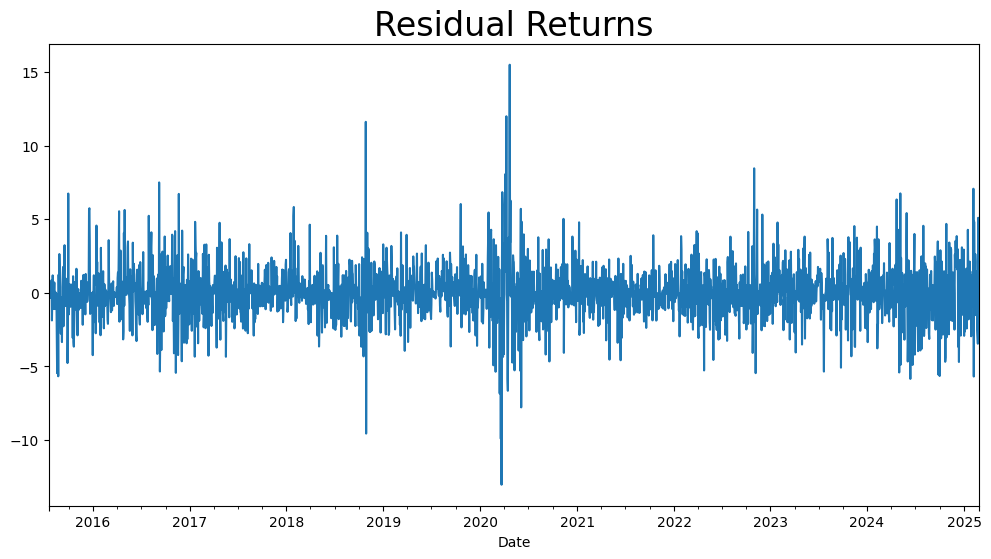

In [74]:
df_Q_close["res_ret_ar_2_ma_2"]= results_ret_ar_2_ma_2.resid

df_Q_close["res_ret_ar_2_ma_2"].plot(figsize=(12,6))
plt.title("Residual Returns", size= 24)
plt.show()

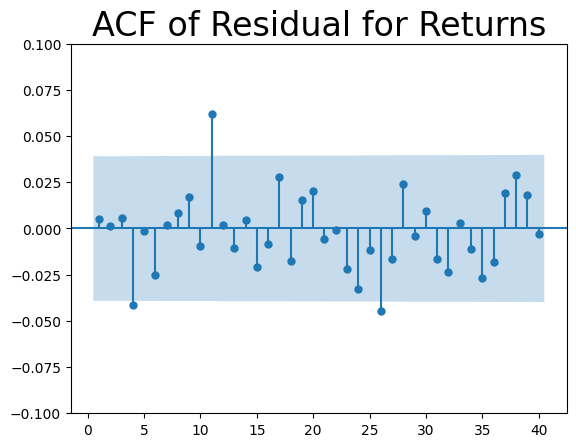

In [75]:
sgt.plot_acf(df_Q_close["res_ret_ar_2_ma_2"], zero= False, lags=40)
plt.title("ACF of Residual for Returns", size= 24)
plt.ylim((-0.1, 0.1))
plt.show()

In [76]:
modelo_ret_ar_11_ma_11 = SARIMAX(df_Q_close["returns"], order=(11, 0, 11), trend='c')
results_ret_ar_11_ma_11= modelo_ret_ar_11_ma_11.fit()
results_ret_ar_11_ma_11.summary()

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 2508
Model:             SARIMAX(11, 0, 11)   Log Likelihood               -5094.818
Date:                Fri, 21 Mar 2025   AIC                          10237.637
Time:                        20:26:37   BIC                          10377.491
Sample:                    07-20-2015   HQIC                         10288.402
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0297      1.042      0.028      0.977      -2.014       2.073
ar.L1         -0.0109      0.930     -0.012      0.991      -1.834       1.812
ar.L2         -0.0681      0.923     -0.074      0.941      -1.878       1.742
ar.L3         -0.1227      0.935     -0.131      0.896      -1.955       1.709
ar.L4         -0.1250      1.023     -0.122      0.903      -2.131       1.881
ar.L5         -0.2294      1.117     -0.205      0.837      -2.419       1.960
ar.L6          0.2905      1.260      0.231      0.818      -2.179       2.760
ar.L7         -0.1379      0.959     -0.144      0.886      -2.017       1.741
ar.L8          0.3356      1.068      0.314      0.753      -1.758       2.430
ar.L9          0.0612      0.807      0.076      0.940      -1.520       1.642
ar.L10         0.1694      0.702      0.241      0.809      -1.206       1.545
ar.L11         0.5555      0.559      0.994      0.320      -0.540       1.651
ma.L1          0.0172      0.930      0.018      0.985      -1.806       1.841
ma.L2          0.0940      0.929      0.101      0.919      -1.727       1.915
ma.L3          0.1331      0.963      0.138      0.890      -1.754       2.020
ma.L4          0.0697      1.060      0.066      0.948      -2.008       2.148
ma.L5          0.2479      1.102      0.225      0.822      -1.913       2.408
ma.L6         -0.2869      1.266     -0.227      0.821      -2.768       2.194
ma.L7          0.1238      0.970      0.128      0.898      -1.777       2.024
ma.L8         -0.3622      1.063     -0.341      0.733      -2.446       1.721
ma.L9         -0.0511      0.783     -0.065      0.948      -1.586       1.484
ma.L10        -0.1610      0.691     -0.233      0.816      -1.516       1.194
ma.L11        -0.5403      0.559     -0.967      0.334      -1.635       0.555
sigma2         3.4058      0.059     58.007      0.000       3.291       3.521
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3202.73
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
modelo_ret_ar_11_ma_1 = SARIMAX(df_Q_close["returns"], order=(11, 0, 2), trend='c')
results_ret_ar_11_ma_1= modelo_ret_ar_11_ma_1.fit()
results_ret_ar_11_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 2508
Model:              SARIMAX(11, 0, 2)   Log Likelihood               -5102.243
Date:                Fri, 21 Mar 2025   AIC                          10234.486
Time:                        20:26:40   BIC                          10321.894
Sample:                    07-20-2015   HQIC                         10266.214
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1014      0.059      1.708      0.088      -0.015       0.218
ar.L1         -0.0159      0.364     -0.044      0.965      -0.728       0.697
ar.L2          0.0670      0.294      0.228      0.820      -0.509       0.643
ar.L3          0.0029      0.018      0.158      0.875      -0.033       0.038
ar.L4         -0.0631      0.017     -3.750      0.000      -0.096      -0.030
ar.L5          0.0084      0.031      0.276      0.783      -0.052       0.068
ar.L6         -0.0051      0.025     -0.202      0.840      -0.055       0.044
ar.L7         -0.0076      0.017     -0.444      0.657      -0.041       0.026
ar.L8         -0.0063      0.018     -0.352      0.725      -0.041       0.029
ar.L9          0.0311      0.016      1.955      0.051   -8.14e-05       0.062
ar.L10        -0.0033      0.022     -0.148      0.883      -0.046       0.040
ar.L11         0.0463      0.020      2.334      0.020       0.007       0.085
ma.L1          0.0193      0.364      0.053      0.958      -0.695       0.733
ma.L2         -0.0440      0.295     -0.149      0.881      -0.623       0.535
sigma2         3.4242      0.058     58.763      0.000       3.310       3.538
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3363.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuos = df_Q_close["res_ret_ar_2_ma_2"]
lb_test = acorr_ljungbox(residuos, lags= 20, return_df=True)

# Convertir el índice a columna y renombrar
lb_test = lb_test.reset_index().rename(columns={"index": "lag"})

print(lb_test[["lag", "lb_stat", "lb_pvalue"]])


    lag    lb_stat  lb_pvalue
0     1   0.064910   0.798897
1     2   0.070627   0.965303
2     3   0.145039   0.985932
3     4   4.453993   0.348038
4     5   4.457960   0.485528
5     6   6.031189   0.419705
6     7   6.039419   0.535154
7     8   6.213046   0.623381
8     9   6.921127   0.645331
9    10   7.141596   0.712013
10   11  16.856354   0.112197
11   12  16.866212   0.154700
12   13  17.145810   0.192724
13   14  17.202510   0.245547
14   15  18.303976   0.247022
15   16  18.482458   0.296411
16   17  20.429004   0.252876
17   18  21.204156   0.269239
18   19  21.807574   0.293937
19   20  22.829692   0.297234


**Conclusión:**

El modelo ARMA(2,2) es suficiente y no se justifica agregar más parámetros. La gráfica del ACF del Residuo de retornos mostraba un puco en el lag 11 se uso la **Prueba Ljung-Box** es una prueba estadística utilizada para determinar si los residuos de un modelo de series temporales presentan autocorrelaciones significativas en múltiples retardos (lags).

Todos los valores fueron mayor al 5% por lo que el modelo ARMA(2,2) es el mejor.

*Siempre examinar los residuos para ver si el modelo es mejorable*

## Modelo ARIMA al market value de Q

In [79]:
model_ar_1_i_1_ma_1= SARIMAX(df_Q_close["Q.MX"], order= (1,1,1), trend= "c")
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Q.MX   No. Observations:                 2508
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4977.249
Date:                Fri, 21 Mar 2025   AIC                           9962.497
Time:                        20:26:42   BIC                           9985.805
Sample:                    07-20-2015   HQIC                          9970.958
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1139      0.055      2.085      0.037       0.007       0.221
ar.L1         -0.5924      0.117     -5.057      0.000      -0.822      -0.363
ma.L1          0.5433      0.122      4.447      0.000       0.304       0.783
sigma2         3.1043      0.035     88.131      0.000       3.035       3.173
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             12359.28
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              41.44   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

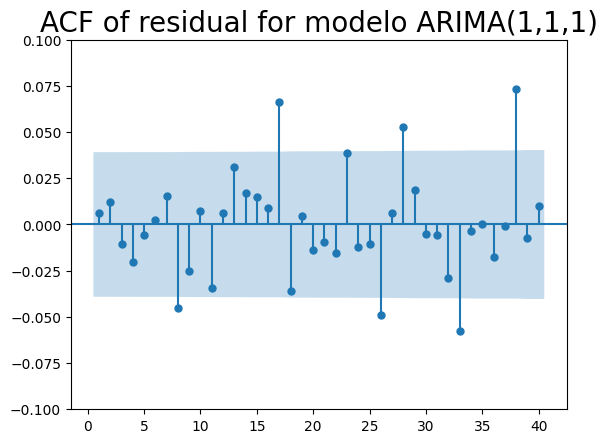

In [80]:
df_Q_close["res_ar_1_i_1_ma_1"]= results_ar_1_i_1_ma_1.resid

sgt.plot_acf(df_Q_close["res_ar_1_i_1_ma_1"][1:], zero=False, lags=40) # se usa [1:] ya que se tiene un valor faltante al inicio
plt.title("ACF of residual for modelo ARIMA(1,1,1)", size=20)
plt.ylim((-0.10, 0.10))
plt.show()

In [81]:
residuos = df_Q_close["res_ar_1_i_1_ma_1"]
lb_test = acorr_ljungbox(residuos, lags= 20, return_df=True)

# Convertir el índice a columna y renombrar
lb_test = lb_test.reset_index().rename(columns={"index": "lag"})

print(lb_test[["lag", "lb_stat", "lb_pvalue"]])

    lag    lb_stat  lb_pvalue
0     1   0.083317   0.772852
1     2   0.423135   0.809315
2     3   0.681961   0.877439
3     4   1.616753   0.805778
4     5   1.702128   0.888632
5     6   1.715277   0.943936
6     7   2.280887   0.942674
7     8   7.178012   0.517554
8     9   8.640633   0.471086
9    10   8.780446   0.553059
10   11  11.509900   0.401585
11   12  11.584810   0.479573
12   13  13.716015   0.394143
13   14  14.371542   0.422414
14   15  14.872594   0.460633
15   16  15.034030   0.522148
16   17  24.921189   0.096488
17   18  28.021065   0.061735
18   19  28.071523   0.082062
19   20  28.526699   0.097506


**Comentario**

Usando la prueba de ***Prueba Ljung-Box*** y le p-valor es mayor de 0.05 entonces: No hay evidencia de autocorrelación. El modelo actual es adecuado.

In [82]:
modelos = {
    "ARIMA(1,1,1)": (1,1,1),
    "ARIMA(2,1,1)": (2,1,1),
    "ARIMA(1,1,2)": (1,1,2),
    "ARIMA(2,1,2)": (2,1,2)
}

results = []
for name, order in modelos.items():
    try:
        model = SARIMAX(df_Q_close["Q.MX"], order=order, trend="c").fit()
        results.append({
            "Modelo": name,
            "AIC": model.aic,
            "BIC": model.bic,
            "Log-Likelihood": model.llf
        })
    except:
        continue

results_df = pd.DataFrame(results).sort_values("AIC")
print(results_df)

         Modelo          AIC          BIC  Log-Likelihood
3  ARIMA(2,1,2)  9949.315129  9984.276181    -4968.657564
0  ARIMA(1,1,1)  9962.497185  9985.804553    -4977.248593
2  ARIMA(1,1,2)  9963.667015  9992.801226    -4976.833508
1  ARIMA(2,1,1)  9963.715729  9992.849939    -4976.857864


c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [83]:
model_ar_2_i_1_ma_2= SARIMAX(df_Q_close["Q.MX"], order= (2,1,2), trend= "c")
results_ar_2_i_1_ma_2 = model_ar_2_i_1_ma_2.fit()
results_ar_2_i_1_ma_2.summary()

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Q.MX   No. Observations:                 2508
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4968.658
Date:                Fri, 21 Mar 2025   AIC                           9949.315
Time:                        20:26:50   BIC                           9984.276
Sample:                    07-20-2015   HQIC                          9962.006
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2525      0.127      1.984      0.047       0.003       0.502
ar.L1         -1.5754      0.002   -768.619      0.000      -1.579      -1.571
ar.L2         -0.9969      0.002   -507.321      0.000      -1.001      -0.993
ma.L1          1.5673      0.002    768.855      0.000       1.563       1.571
ma.L2          0.9966      0.002    460.200      0.000       0.992       1.001
sigma2         3.1055      0.036     87.229      0.000       3.036       3.175
===================================================================================
Ljung-Box (L1) (Q):                   2.00   Jarque-Bera (JB):             12412.26
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):              41.25   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
print(LLR_test(results_ar_1_i_1_ma_1, results_ar_2_i_1_ma_2))

(17.182056583535086, 2, 0.0002)


Por lo anterior, tenemos que los residuos del Modelo ARIMA(1,1,1) y la gráfica ACF muestra que no hay autocorrelación con retrasos mayores pero el modelo ARIMA(2,1,2) y la prueba LLR_test muestra que es significativamente mejor que su predecesor.

##### ¿Por qué hay discrepancia?
La LLR detecta mejoras no capturadas por la Ljung-Box:

La prueba LLR no solo evalúa autocorrelación, sino cualquier mejora en la estructura del modelo (ej: relaciones no lineales, ajuste a patrones complejos).

ARIMA(2,1,2) podría estar modelando mejor la varianza, tendencias no lineales o interacciones entre términos AR y MA que no se reflejan en la autocorrelación de los residuos.

La Ljung-Box solo verifica ruido blanco:

Aunque los residuos de ARIMA(1,1,1) son ruido blanco, el modelo ARIMA(2,1,2) podría ajustar mejor la serie sin necesariamente alterar la autocorrelación residual.

Hasta este momento tendríamos que el modelo ARIMA (2,1,2) es el mejor falta verificar si sus residuos son ruido blanco.

In [85]:
# Prueba Ljung-Box para ARIMA(2,1,2)
residuos_complejos = results_ar_2_i_1_ma_2.resid
lb_test_complex = acorr_ljungbox(residuos_complejos, lags=20, return_df=True)
print(lb_test_complex[["lb_stat", "lb_pvalue"]])

      lb_stat  lb_pvalue
1    1.834832   0.175558
2    3.410317   0.181744
3    4.290116   0.231793
4    4.410351   0.353310
5    5.533685   0.354266
6    6.418199   0.378008
7    6.433640   0.490123
8   10.149358   0.254699
9   11.011402   0.274928
10  11.034180   0.354861
11  11.996597   0.363899
12  12.037095   0.442705
13  14.338943   0.350414
14  15.431177   0.349329
15  15.452781   0.419321
16  16.197974   0.439231
17  24.052581   0.118013
18  27.506560   0.069972
19  28.007128   0.083292
20  29.749468   0.074016


#### 1. Interpretación de lb_pvalue en la prueba Ljung-Box
Si algún lb_pvalue en los resultados de la prueba Ljung-Box para el modelo ARIMA(2,1,2) es menor que 0.05, esto indica que existe autocorrelación significativa en los residuos en ese retardo específico. Por lo tanto:

* Consecuencia: Los residuos **no son ruido blanco**, lo que sugiere que el modelo no está capturando toda la estructura de autocorrelación de los datos en ese lag.

* Acción recomendada:

    * Ajustar el modelo para incluir más términos AR o MA.

    * Considerar componentes estacionales (SARIMA) si los lags significativos siguen un patrón (ej: cada 12 meses).

    * Evaluar si hay valores atípicos o cambios estructurales en la serie.

In [86]:
model_ar_3_i_1_ma_3= SARIMAX(df_Q_close["Q.MX"], order= (3,1,3), trend= "c")
results_ar_3_i_1_ma_3 = model_ar_3_i_1_ma_3.fit()
results_ar_3_i_1_ma_3.summary()

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Q.MX   No. Observations:                 2508
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -4970.620
Date:                Fri, 21 Mar 2025   AIC                           9957.239
Time:                        20:26:54   BIC                          10003.854
Sample:                    07-20-2015   HQIC                          9974.160
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1512      0.073      2.082      0.037       0.009       0.294
ar.L1          0.0261      0.055      0.474      0.635      -0.082       0.134
ar.L2         -0.2120      0.050     -4.248      0.000      -0.310      -0.114
ar.L3         -0.8646      0.057    -15.219      0.000      -0.976      -0.753
ma.L1         -0.0404      0.059     -0.682      0.495      -0.156       0.076
ma.L2          0.2381      0.054      4.402      0.000       0.132       0.344
ma.L3          0.8337      0.061     13.642      0.000       0.714       0.954
sigma2         3.0891      0.036     86.509      0.000       3.019       3.159
===================================================================================
Ljung-Box (L1) (Q):                   2.87   Jarque-Bera (JB):             12154.99
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):              41.10   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
print(LLR_test(results_ar_2_i_1_ma_2, results_ar_3_i_1_ma_3))

(-3.924025297488697, 2, 1.0)


El modelo ARIMA(3,1,3) no es significativamente mejor que el (2,1,2)

## Predicciones del modelo ARIMA

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE ARIMA(1,1,1): 66.5542
RMSE ARIMA(2,1,2): 40.4316


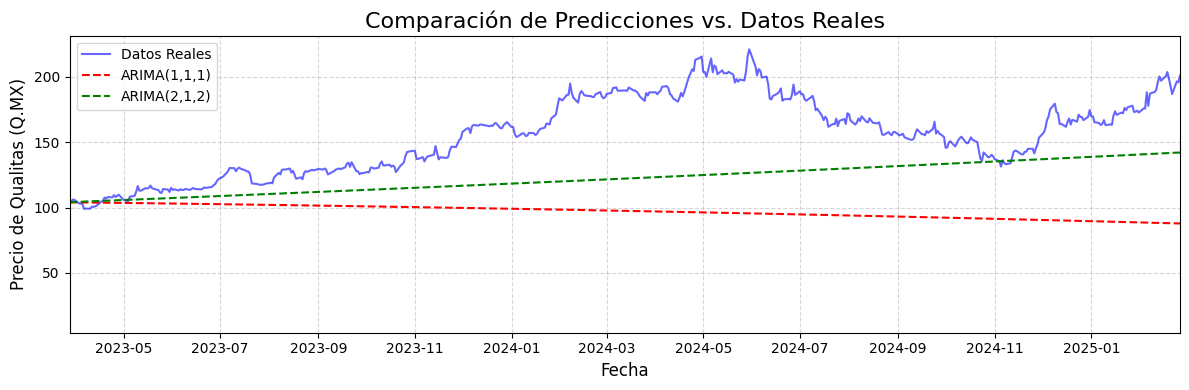

In [88]:
# Dividir la serie en train y test (ej: 80-20)
train_size = int(len(df_Q_close["Q.MX"]) * 0.8)
train = df_Q_close["Q.MX"].iloc[:train_size]
test = df_Q_close["Q.MX"].iloc[train_size:]

model_1 = SARIMAX(train, order=(1,1,1), trend="ct").fit() #Añade tendencia (trend="ct") y estacionalidad
forecast_1 = model_1.get_forecast(steps=len(test))
pred_1 = forecast_1.predicted_mean
rmse_1 = np.sqrt(mean_squared_error(test, pred_1))

# Modelo 2: ARIMA(2,1,2)
model_2 = SARIMAX(train, order=(2,1,2), trend="ct").fit() #Añade tendencia (trend="ct")
forecast_2 = model_2.get_forecast(steps=len(test))
pred_2 = forecast_2.predicted_mean
rmse_2 = np.sqrt(mean_squared_error(test, pred_2))

print(f"RMSE ARIMA(1,1,1): {rmse_1:.4f}")
print(f"RMSE ARIMA(2,1,2): {rmse_2:.4f}")

# Configurar figura
plt.figure(figsize=(12, 4))

# Graficar datos reales
plt.plot(df_Q_close["Q.MX"].index, df_Q_close["Q.MX"], label="Datos Reales", color="blue", alpha=0.6)

# Graficar predicciones de ARIMA(1,1,1)
plt.plot(test.index, pred_1, label="ARIMA(1,1,1)", color="red", linestyle="--", linewidth=1.5)

# Graficar predicciones de ARIMA(2,1,2)
plt.plot(test.index, pred_2, label="ARIMA(2,1,2)", color="green", linestyle="--", linewidth=1.5)

# Añadir detalles
plt.title("Comparación de Predicciones vs. Datos Reales", fontsize=16)
plt.xlim(test.index.min(), test.index.max())  # Enfocar solo en el período de prueba
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio de Qualitas (Q.MX)", fontsize=12)
plt.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Modelo SARIMAX (pendiente falta ver como encontrar los valores de la estacionalidad(Q,D,P, n= periodo(semestre, años, etc)))

## Modelo ARCH

El modelo ARCH (AutoRegressive Conditional Heteroskedasticity) es una herramienta estadística diseñada para modelar y predecir la **volatilidad** (varianza condicional) de una serie temporal, especialmente útil en datos financieros donde la volatilidad no es constante (heterocedasticidad condicional)

#### 2. ¿Por qué usar ARCH?

* **Pronosticar volatilidad**: Útil para estimar riesgo financiero (ej: valor en riesgo, opciones).

* **Detectar clusters de volatilidad**: Periodos de alta/baja variabilidad en los datos.

* **Mejorar modelos ARIMA**: Modelar media y varianza por separado (ej: ARIMA para la media, ARCH para la varianza).

#### Conclusión
* ARCH modela la volatilidad como una función de errores pasados al cuadrado.

* Uso en finanzas: Predicción de riesgo, optimización de portafolios, valoración de opciones.

In [89]:
display(df_Q_close.head())

,Q.MX,wn,trend,mensual Q,semestral Q,EWMA mensual Q,EWMA semestral Q,EWMA 6 meses,SE 6 meses,DESadd6,res_price,returns,res_ret_ar_2_ma_2,res_ar_1_i_1_ma_1
Date,,,,,,,,,,,,,,
2015-07-20,20.915588,3.692778,-6.423013,NaN,NaN,20.949661,20.952625,20.952625,20.952625,20.991686,-0.057746,-0.179727,-0.287021,20.844047
2015-07-21,20.870396,141.194921,-6.359518,NaN,NaN,20.942111,20.951265,20.951265,20.951265,20.947007,-0.066049,-0.216072,-0.324183,-0.116731
2015-07-22,20.953247,-35.290687,-6.296022,NaN,NaN,20.943172,20.951298,20.951298,20.951298,21.024528,0.062512,0.396981,0.295040,0.005345
2015-07-23,20.923119,5.886043,-6.232526,NaN,NaN,20.941262,20.950832,20.950832,20.950832,20.998899,-0.044827,-0.143789,-0.244077,-0.097872
2015-07-24,20.877928,109.208946,-6.169030,NaN,NaN,20.935230,20.949627,20.949627,20.949627,20.954526,-0.069939,-0.215985,-0.336996,-0.123802


In [90]:
# Creando retornos al cuadrado

df_Q_close["sq_returns"]= df_Q_close["returns"].mul(df_Q_close["returns"])

### Returns vs Squared Returns

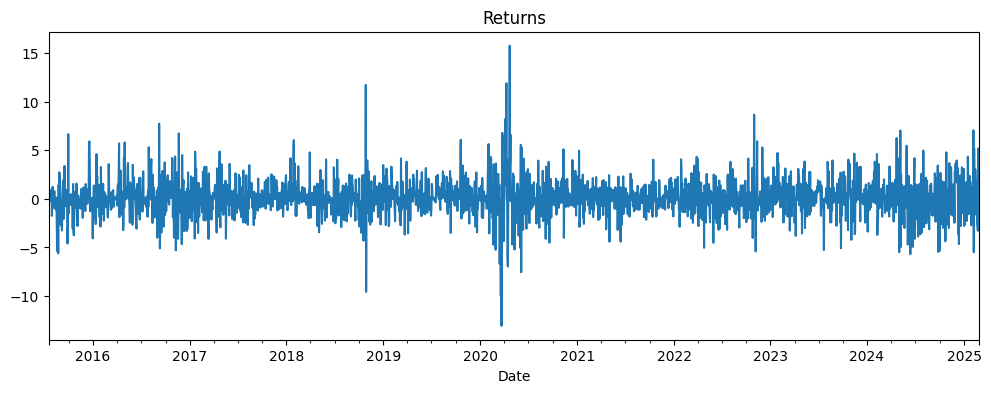

In [91]:
df_Q_close["returns"].plot(figsize=(12,4))
plt.title("Returns")
plt.show()

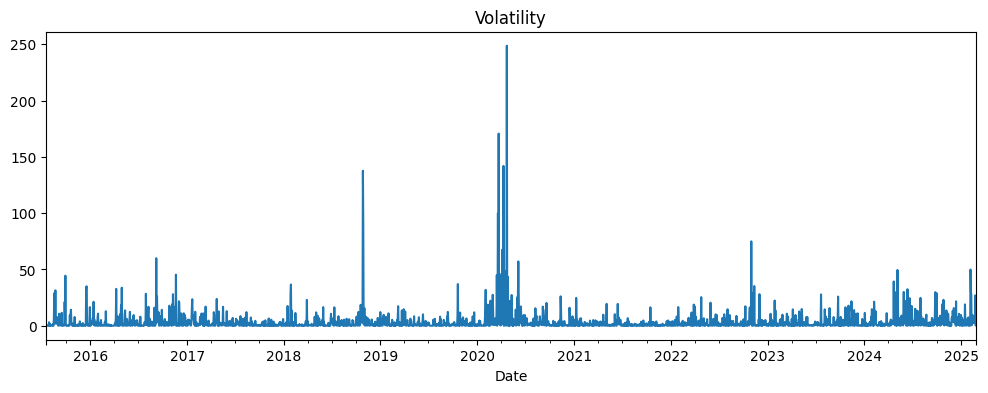

In [92]:
df_Q_close["sq_returns"].plot(figsize=(12,4))
plt.title("Volatility")
plt.show()

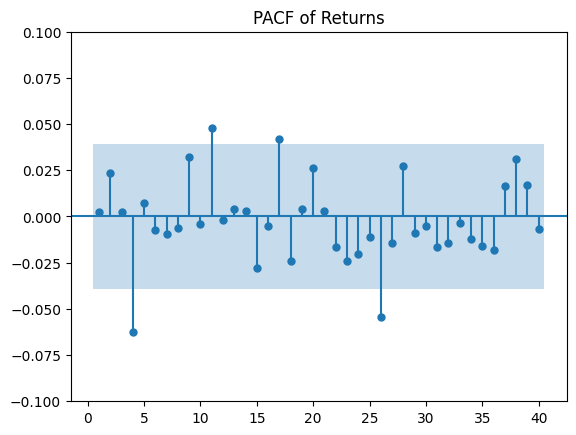

In [93]:
sgt.plot_pacf(df_Q_close["returns"], lags= 40, alpha= 0.05, zero= False, method= "ols")
plt.title("PACF of Returns")
plt.ylim((-0.1, 0.1))
plt.show()

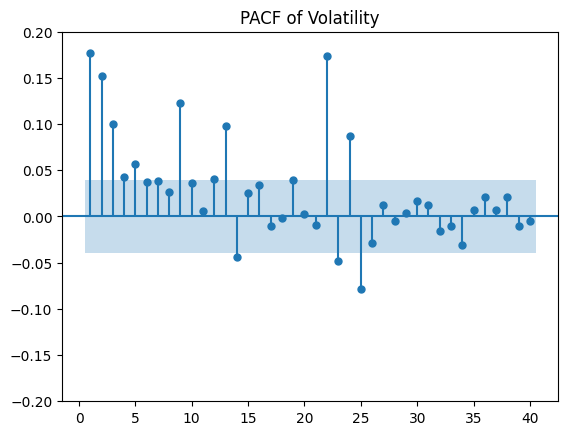

In [94]:
sgt.plot_pacf(df_Q_close["sq_returns"], lags= 40, alpha= 0.05, zero= False, method= "ols")
plt.title("PACF of Volatility")
plt.ylim((-0.2, 0.2))
plt.show()

In [95]:
from arch import arch_model

In [96]:
model_arch_1 = arch_model(df_Q_close["returns"])
results_arch_1 = model_arch_1.fit()
results_arch_1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15324.587794496305
Iteration:      2,   Func. Count:     15,   Neg. LLF: 9925.59543682387
Iteration:      3,   Func. Count:     23,   Neg. LLF: 905244948.0056968
Iteration:      4,   Func. Count:     29,   Neg. LLF: 4924.303313731807
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5672.56876886496
Iteration:      6,   Func. Count:     41,   Neg. LLF: 4899.448854215529
Iteration:      7,   Func. Count:     47,   Neg. LLF: 4896.720293860873
Iteration:      8,   Func. Count:     53,   Neg. LLF: 4894.551893569222
Iteration:      9,   Func. Count:     58,   Neg. LLF: 4894.549605203343
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4894.549590337341
Iteration:     11,   Func. Count:     68,   Neg. LLF: 4894.5495893101
Iteration:     12,   Func. Count:     72,   Neg. LLF: 4894.549589309617
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4894.5495893101
            Iterations: 12
      

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4894.55
Distribution:                  Normal   AIC:                           9797.10
Method:            Maximum Likelihood   BIC:                           9820.41
                                        No. Observations:                 2508
Date:                Fri, Mar 21 2025   Df Residuals:                     2507
Time:                        20:27:00   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1241  3.150e-02      3.938  8.217e-05 [6.231e-02,  0.186]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2465  8.094e-02      3.045  2.324e-03 [8.785e-02,  0.405]
alpha[1]       0.1367  2.962e-02      4.614  3.954e-06 [7.861e-02,  0.195]
beta[1]        0.7927  4.659e-02     17.013  6.612e-65   [  0.701,  0.884]
==========================================================================

Covariance estimator: robust
"""

### The Simple ARCH(1)

In [97]:
model_arch_1= arch_model(df_Q_close["returns"], mean= "Constant", vol= "ARCH", p= 1)
results_arch_1 = model_arch_1.fit()
results_arch_1.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 7838.461569879744
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5492.19815796787
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5333.655809300084
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4997.315828812678
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4997.315823850918
Iteration:      6,   Func. Count:     31,   Neg. LLF: 4997.315823850833
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4997.315823850918
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4997.32
Distribution:                  Normal   AIC:                           10000.6
Method:            Maximum Likelihood   BIC:                           10018.1
                                        No. Observations:                 2508
Date:                Fri, Mar 21 2025   Df Residuals:                     2507
Time:                        20:27:00   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1019  3.423e-02      2.978  2.897e-03 [3.486e-02,  0.169]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.3782      0.139     17.154  5.846e-66 [  2.106,  2.650]
alpha[1]       0.3479  7.294e-02      4.769  1.849e-06 [  0.205,  0.491]
========================================================================

Covariance estimator: robust
"""

### Higher-Lag ARCH Models

In [98]:
model_arch_2= arch_model(df_Q_close["returns"], mean= "Constant", vol= "ARCH", p= 2)
results_arch_2 = model_arch_2.fit()
results_arch_2.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8993.42127400661
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5217.430483356482
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1545056.605658011
Iteration:      4,   Func. Count:     27,   Neg. LLF: 5004.179535346833
Iteration:      5,   Func. Count:     33,   Neg. LLF: 5002.718646265779
Iteration:      6,   Func. Count:     40,   Neg. LLF: 4956.508026546591
Iteration:      7,   Func. Count:     45,   Neg. LLF: 4956.503119476631
Iteration:      8,   Func. Count:     50,   Neg. LLF: 4956.503052874436
Iteration:      9,   Func. Count:     55,   Neg. LLF: 4956.503050143163
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4956.503050143137
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4956.503050143163
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4956.50
Distribution:                  Normal   AIC:                           9921.01
Method:            Maximum Likelihood   BIC:                           9944.32
                                        No. Observations:                 2508
Date:                Fri, Mar 21 2025   Df Residuals:                     2507
Time:                        20:27:00   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0991  3.287e-02      3.016  2.561e-03 [3.472e-02,  0.164]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          2.0420      0.136     15.060  2.973e-51   [  1.776,  2.308]
alpha[1]       0.2887  5.722e-02      5.046  4.514e-07   [  0.177,  0.401]
alpha[2]       0.1423  3.562e-02      3.996  6.454e-05 [7.252e-02,  0.212]
==========================================================================

Covariance estimator: robust
"""

In [99]:
model_arch_3= arch_model(df_Q_close["returns"], mean= "Constant", vol= "ARCH", p= 3)
results_arch_3 = model_arch_3.fit()
results_arch_3.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 8682.064968119423
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5091.163792245846
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1879664.8834253233
Iteration:      4,   Func. Count:     32,   Neg. LLF: 5158.287362433831
Iteration:      5,   Func. Count:     40,   Neg. LLF: 4962.186040790749
Iteration:      6,   Func. Count:     47,   Neg. LLF: 4974.71332068019
Iteration:      7,   Func. Count:     55,   Neg. LLF: 4937.189035143858
Iteration:      8,   Func. Count:     62,   Neg. LLF: 4935.425060673205
Iteration:      9,   Func. Count:     68,   Neg. LLF: 4935.425023478758
Iteration:     10,   Func. Count:     73,   Neg. LLF: 4935.425023478851
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4935.425023478758
            Iterations: 10
            Function evaluations: 73
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4935.43
Distribution:                  Normal   AIC:                           9880.85
Method:            Maximum Likelihood   BIC:                           9909.99
                                        No. Observations:                 2508
Date:                Fri, Mar 21 2025   Df Residuals:                     2507
Time:                        20:27:00   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0997  3.222e-02      3.093  1.979e-03 [3.652e-02,  0.163]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.8656      0.138     13.502  1.527e-41   [  1.595,  2.136]
alpha[1]       0.2473  4.826e-02      5.124  2.995e-07   [  0.153,  0.342]
alpha[2]       0.1374  3.701e-02      3.713  2.046e-04 [6.489e-02,  0.210]
alpha[3]       0.0854  2.904e-02      2.941  3.275e-03 [2.848e-02,  0.142]
==========================================================================

Covariance estimator: robust
"""

In [100]:
model_arch_4= arch_model(df_Q_close["returns"], mean= "Constant", vol= "ARCH", p= 4)
results_arch_4 = model_arch_4.fit()
results_arch_4.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 7208.965779556025
Iteration:      2,   Func. Count:     17,   Neg. LLF: 5383.854061056502
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3669486.1267367797
Iteration:      4,   Func. Count:     34,   Neg. LLF: 5164.300623839077
Iteration:      5,   Func. Count:     43,   Neg. LLF: 4964.767594988406
Iteration:      6,   Func. Count:     51,   Neg. LLF: 4950.971671260545
Iteration:      7,   Func. Count:     60,   Neg. LLF: 4950.068257418454
Iteration:      8,   Func. Count:     69,   Neg. LLF: 4948.443777106902
Iteration:      9,   Func. Count:     77,   Neg. LLF: 4918.751491360641
Iteration:     10,   Func. Count:     84,   Neg. LLF: 4918.751261278875
Iteration:     11,   Func. Count:     91,   Neg. LLF: 4918.75123193819
Iteration:     12,   Func. Count:     98,   Neg. LLF: 4918.751231286156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4918.751231286156
            Iterations: 12
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4918.75
Distribution:                  Normal   AIC:                           9849.50
Method:            Maximum Likelihood   BIC:                           9884.47
                                        No. Observations:                 2508
Date:                Fri, Mar 21 2025   Df Residuals:                     2507
Time:                        20:27:00   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1022  3.187e-02      3.206  1.347e-03 [3.970e-02,  0.165]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.7024      0.137     12.423  1.952e-35   [  1.434,  1.971]
alpha[1]       0.2384  4.668e-02      5.108  3.263e-07   [  0.147,  0.330]
alpha[2]       0.1118  3.167e-02      3.531  4.138e-04 [4.976e-02,  0.174]
alpha[3]       0.0786  2.988e-02      2.630  8.547e-03 [2.001e-02,  0.137]
alpha[4]       0.0854  2.848e-02      2.997  2.728e-03 [2.953e-02,  0.141]
==========================================================================

Covariance estimator: robust
"""

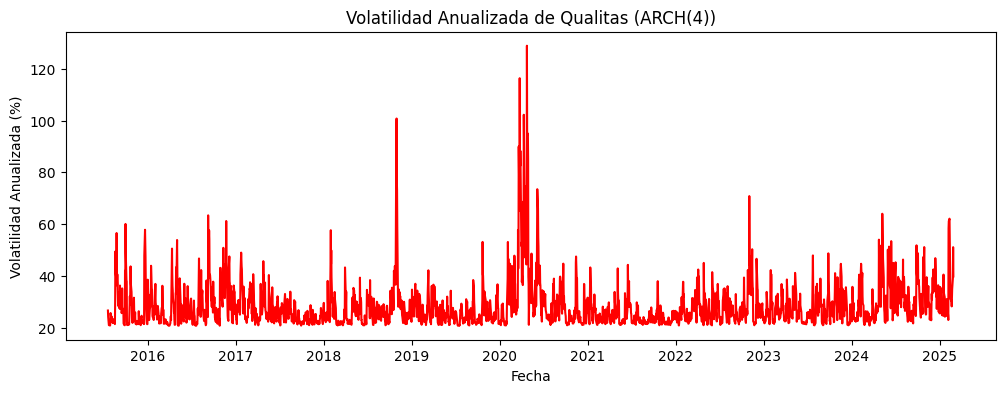

In [101]:
# Volatilidad condicional (desviación estándar)
volatilidad = results_arch_4.conditional_volatility

# Convertir a anualizada (ej: datos diarios, 252 días hábiles)
volatilidad_anualizada = volatilidad * np.sqrt(252)

# Gráfico de la volatilidad
plt.figure(figsize=(12, 4))
plt.plot(volatilidad_anualizada, color="red")
plt.title("Volatilidad Anualizada de Qualitas (ARCH(4))")
plt.ylabel("Volatilidad Anualizada (%)")
plt.xlabel("Fecha")
plt.show()

El mayor modelo arch con coeficientes siginificativos distintos de cero es ARCH(4)

### Validación del Modelo ARCH(4)

Verifica que los residuos estandarizados ($ϵ_t / σ_t$) sean ruido blanco:

In [102]:
# Residuos estandarizados
std_resid = results_arch_4.resid / results_arch_4.conditional_volatility

# Prueba Ljung-Box en residuos y residuos al cuadrado (hasta lag 10)
lb_test_resid = acorr_ljungbox(std_resid, lags=20, return_df=True)
lb_test_sq = acorr_ljungbox(std_resid**2, lags=20, return_df=True)

print("Ljung-Box para residuos:\n", lb_test_resid[["lb_pvalue"]])
print("\nLjung-Box para residuos al cuadrado:\n", lb_test_sq[["lb_pvalue"]])

Ljung-Box para residuos:
     lb_pvalue
1    0.791659
2    0.929526
3    0.979410
4    0.686406
5    0.711189
6    0.746141
7    0.836717
8    0.882734
9    0.895300
10   0.885737
11   0.815854
12   0.849618
13   0.807329
14   0.806349
15   0.856744
16   0.896270
17   0.809949
18   0.752333
19   0.796706
20   0.834898

Ljung-Box para residuos al cuadrado:
     lb_pvalue
1    0.859806
2    0.929256
3    0.979547
4    0.751525
5    0.765899
6    0.601961
7    0.235510
8    0.100052
9    0.125258
10   0.012190
11   0.018826
12   0.012012
13   0.004081
14   0.006595
15   0.001438
16   0.000317
17   0.000205
18   0.000323
19   0.000516
20   0.000768


**Residuos al cuadrado (volatilidad):**

$p<0.05$ en lags altos (ej: 10): Existe autocorrelación significativa en la varianza condicional.

* **Problema**: El modelo ARCH(4) no está capturando toda la estructura de la volatilidad. Los lags altos significativos sugieren que:

    * La volatilidad tiene memoria larga (los choques pasados afectan la volatilidad actual más allá de 4 períodos).

    * Podrías necesitar un modelo GARCH (que incluye memoria de la varianza pasada) o ARCH con más lags.

## Modelo GARCH

El modelo GARCH(1,1) se considera el estándar para series de precios de acciones (y otros activos financieros) debido a las siguientes razones:

### 1. Persistencia de la Volatilidad

Los mercados financieros exhiben clusters de volatilidad, donde periodos de alta volatilidad tienden a seguir a otros similares, y lo mismo ocurre con periodos de baja volatilidad. El modelo GARCH(1,1) captura esta persistencia mediante:

Componente ARCH(1): Refleja el impacto inmediato de shocks pasados en la volatilidad actual (ej: noticias recientes).

Componente GARCH(1): Modela la "memoria" de la volatilidad pasada, permitiendo que los choques afecten la volatilidad a largo plazo.

La ecuación de la varianza condicional en GARCH(1,1) es:

$σ_t^2 = ω +αϵ_{t-1}^2 + βσ_{t-1}^2$ ,

donde:

* $ω>0$, $α≥0$, $β≥0$ (para garantizar varianza positiva).

* $α+β<1$ (condición de estacionariedad).

### 2.  Interpretación Económica

* **Persistencia de la volatilidad**: La suma $α+β$ cuantifica cuánto persisten los choques en el tiempo.

    * Si $α+β≈1$, la volatilidad tiene memoria larga (choques pasados afectan indefinidamente).

    * Ejemplo: Si $α=0.1$ y $β=0.85$, $α+β=0.95$, indicando alta persistencia.



In [103]:
model_garch_1_1 = arch_model(df_Q_close["returns"], mean= "constant", vol= "GARCH", p=1, q=1)
results_garch_1_1= model_garch_1_1.fit(update_freq= 5)
results_garch_1_1.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 5672.56876886496
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4894.549590337341
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4894.5495893101
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4894.55
Distribution:                  Normal   AIC:                           9797.10
Method:            Maximum Likelihood   BIC:                           9820.41
                                        No. Observations:                 2508
Date:                Fri, Mar 21 2025   Df Residuals:                     2507
Time:                        20:27:00   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1241  3.150e-02      3.938  8.217e-05 [6.231e-02,  0.186]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2465  8.094e-02      3.045  2.324e-03 [8.785e-02,  0.405]
alpha[1]       0.1367  2.962e-02      4.614  3.954e-06 [7.861e-02,  0.195]
beta[1]        0.7927  4.659e-02     17.013  6.612e-65   [  0.701,  0.884]
==========================================================================

Covariance estimator: robust
"""

In [104]:
model_garch_1_2 = arch_model(df_Q_close["returns"], mean= "constant", vol= "GARCH", p=1, q=2)
results_garch_1_2= model_garch_1_2.fit(update_freq= 5)
results_garch_1_2.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 4909.335926201426
Iteration:     10,   Func. Count:     74,   Neg. LLF: 4890.648625760647
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4890.648625760647
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4890.65
Distribution:                  Normal   AIC:                           9791.30
Method:            Maximum Likelihood   BIC:                           9820.43
                                        No. Observations:                 2508
Date:                Fri, Mar 21 2025   Df Residuals:                     2507
Time:                        20:27:00   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1238  3.159e-02      3.920  8.868e-05 [6.191e-02,  0.186]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.2868  8.641e-02      3.319  9.040e-04 [  0.117,  0.456]
alpha[1]       0.1690  3.272e-02      5.164  2.419e-07 [  0.105,  0.233]
beta[1]        0.4471      0.105      4.274  1.918e-05 [  0.242,  0.652]
beta[2]        0.3020  9.840e-02      3.069  2.150e-03 [  0.109,  0.495]
========================================================================

Covariance estimator: robust
"""

In [105]:
# Extraer log-verosimilitudes
loglik_garch11 = results_garch_1_1.loglikelihood
loglik_garch12 = results_garch_1_2.loglikelihood

# Calcular estadístico LRT
lrt_stat = 2 * (loglik_garch12 - loglik_garch11)
df = 1  # beta2 es el parámetro adicional

# Calcular p-valor
from scipy.stats import chi2
p_value = 1 - chi2.cdf(lrt_stat, df)

# Resultado
print(f"Estadístico LRT: {lrt_stat:.4f}")
print(f"p-valor: {p_value:.4f}")

# Regla de decisión (alpha=0.05)
if p_value < 0.05:
    print("Rechazamos H0: GARCH(1,2) es significativamente mejor.")
else:
    print("No hay evidencia para rechazar H0: GARCH(1,1) es suficiente.")

Estadístico LRT: 7.8019
p-valor: 0.0052
Rechazamos H0: GARCH(1,2) es significativamente mejor.


### Conclusiones para Qualitas

1. Estructura de volatilidad compleja:

* La volatilidad de Qualitas no sigue un proceso simple de "memoria corta" (GARCH(1,1)). Requiere un modelo con mayor profundidad en los lags de varianza para capturar dependencias más persistentes o efectos de shocks antiguos.

2. Implicaciones para el mercado:

* La necesidad de un GARCH(1,2) sugiere que la volatilidad de Qualitas está influenciada por múltiples fuentes de riesgo pasadas (e.g., noticias, eventos financieros) que tienen efectos prolongados en el tiempo. Esto podría estar relacionado con:

    * Sector de seguros o servicios financieros (si Qualitas opera en ellos), donde la volatilidad suele ser más persistente.

    * Eventos específicos en la historia de Qualitas (crisis, expansiones, etc.) que dejaron huella en la varianza.

3. Precisión en la gestión de riesgos:

* Usar GARCH(1,1) subestimaría o sobreestimaría el riesgo (VaR, CVaR) de Qualitas. El GARCH(1,2) proporciona estimaciones de volatilidad más precisas, crucial para:

    * Estrategias de cobertura (hedging).

    * Valoración de opciones.

    * Decisiones de inversión a corto plazo.

4. Posible asimetría o clusters de volatilidad:

* Aunque no se menciona un modelo GARCH asimétrico (e.g., EGARCH o TGARCH), el resultado sugiere que Qualitas podría exhibir clusters de volatilidad más largos que los capturados por un modelo simple. Esto es típico en activos con alta exposición a ciclos económicos o eventos recurrentes.


**Resumen Ejecutivo**

Los datos de Qualitas muestran que la volatilidad tiene una dependencia significativa de dos lags pasados de la varianza, lo que hace al GARCH(1,2) superior al GARCH(1,1). Esto implica:

* Mayor precisión en la modelación de riesgo.

* La volatilidad de Qualitas tiene memoria más larga de lo esperado.

* Se recomienda usar GARCH(1,2) para decisiones financieras relacionadas con este activo.

## Modelo Auto ARIMA

In [106]:
# Dividir la serie de returns en train y test (ej: 80-20)
ret_train_size = int(len(df_Q_close["returns"]) * 0.8)
ret_train = df_Q_close["returns"].iloc[:train_size]
ret_test = df_Q_close["returns"].iloc[train_size:]

In [107]:
print(ret_train)
print(ret_test)

Date
2015-07-20   -0.179727
2015-07-21   -0.216072
2015-07-22    0.396981
2015-07-23   -0.143789
2015-07-24   -0.215985
                ...   
2023-03-21    0.000000
2023-03-22   -1.782167
2023-03-23    0.510883
2023-03-24   -0.350541
2023-03-27   -0.562836
Freq: B, Name: returns, Length: 2006, dtype: float64
Date
2023-03-28    1.264708
2023-03-29   -0.489081
2023-03-30    1.255044
2023-03-31   -0.277369
2023-04-03   -2.451106
                ...   
2025-02-20   -2.819741
2025-02-21   -3.290159
2025-02-24    5.186182
2025-02-25   -0.371821
2025-02-26    2.546010
Freq: B, Name: returns, Length: 502, dtype: float64


In [108]:
from pmdarima import auto_arima
model_auto= auto_arima(ret_train)



In [109]:
model_auto

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [110]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2006
Model:                        SARIMAX   Log Likelihood               -4047.361
Date:                Fri, 21 Mar 2025   AIC                           8098.723
Time:                        20:27:04   BIC                           8109.931
Sample:                    07-20-2015   HQIC                          8102.838
                         - 03-27-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0963      0.041      2.343      0.019       0.016       0.177
sigma2         3.3114      0.048     69.568      0.000       3.218       3.405
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):              5269.86
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
# Definir el ticker de Quálitas en la Bolsa Mexicana de Valores
# Configuración inicial
ticker_symbol = "^MXX"
csv_filename = "indice_de_la_Bolsa Mexicana_prices.csv"
start_date = "2015-07-17"

# Verificar si el CSV existe
if os.path.exists(csv_filename):
    print(f"Cargando datos locales desde {csv_filename}...")
    df_ipc_mexico_all = pd.read_csv(csv_filename, index_col="Date", parse_dates=True)
else:
    print("Descargando datos desde Yahoo Finance...")
    
    # Configurar sesión con headers
    session = requests.Session()
    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
    })
    
    ticker = yf.Ticker(ticker_symbol, session=session)
    max_retries = 3
    retry_delay = 5
    success = False
    
    for attempt in range(max_retries):
        try:
            df_ipc_mexico_all = ticker.history(start=start_date, end= "2025-02-27")
            df_ipc_mexico_all.to_csv(csv_filename)
            print(f"Datos guardados en {csv_filename}.")
            success = True
            break
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429:
                print(f"Intento {attempt+1}: Rate limit. Esperando {retry_delay} segundos...")
                time.sleep(retry_delay)
                retry_delay *= 2
            else:
                print(f"Error HTTP: {e}")
                break
        except Exception as e:
            print(f"Error inesperado: {str(e)}")
            break
    
    if not success:
        print("No se pudo descargar. Verifica el ticker o espera unas horas.")

# Mostrar datos
if 'df_ipc_mexico_all' in locals():
    print("\nEjemplo de datos:")
    print(df_ipc_mexico_all.head())
else:
    print("No hay datos disponibles.")

Cargando datos locales desde indice_de_la_Bolsa Mexicana_prices.csv...

Ejemplo de datos:
                                   Open          High           Low  \
Date                                                                  
2015-07-17 00:00:00-05:00  45347.808594  45387.691406  45087.488281   
2015-07-20 00:00:00-05:00  45325.578125  45655.730469  45228.191406   
2015-07-21 00:00:00-05:00  45568.621094  45664.769531  45387.808594   
2015-07-22 00:00:00-05:00  45394.199219  45447.078125  44660.359375   
2015-07-23 00:00:00-05:00  44671.289062  44894.738281  44599.531250   

                                  Close     Volume  Dividends  Stock Splits  
Date                                                                         
2015-07-17 00:00:00-05:00  45325.378906  136764800        0.0           0.0  
2015-07-20 00:00:00-05:00  45567.988281  107843000        0.0           0.0  
2015-07-21 00:00:00-05:00  45401.230469  199521500        0.0           0.0  
2015-07-22 00:00:00-05

In [112]:
df_ipc_mexico_all

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-07-17 00:00:00-05:00,45347.808594,45387.691406,45087.488281,45325.378906,136764800,0.0,0.0
2015-07-20 00:00:00-05:00,45325.578125,45655.730469,45228.191406,45567.988281,107843000,0.0,0.0
2015-07-21 00:00:00-05:00,45568.621094,45664.769531,45387.808594,45401.230469,199521500,0.0,0.0
2015-07-22 00:00:00-05:00,45394.199219,45447.078125,44660.359375,44670.421875,306545700,0.0,0.0
2015-07-23 00:00:00-05:00,44671.289062,44894.738281,44599.531250,44836.328125,245301700,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-20 00:00:00-06:00,54118.460938,54506.941406,53824.121094,54303.929688,136034500,0.0,0.0
2025-02-21 00:00:00-06:00,54310.000000,54382.210938,53462.898438,53738.750000,92877500,0.0,0.0
2025-02-24 00:00:00-06:00,53784.449219,53980.449219,53250.300781,53704.449219,153016300,0.0,0.0


In [113]:
df_exg= df_ipc_mexico_all["Close"].to_frame()
# Cambiar la columna "Close" a "Q.MX"
df_exg = df_exg.rename(columns={"Close": "ipc_mexico"})
display(df_exg)

,ipc_mexico
Date,
2015-07-17 00:00:00-05:00,45325.378906
2015-07-20 00:00:00-05:00,45567.988281
2015-07-21 00:00:00-05:00,45401.230469
2015-07-22 00:00:00-05:00,44670.421875
2015-07-23 00:00:00-05:00,44836.328125
...,...
2025-02-20 00:00:00-06:00,54303.929688
2025-02-21 00:00:00-06:00,53738.750000
2025-02-24 00:00:00-06:00,53704.449219


In [114]:
# Paso 1: Convertir el índice a datetime con utc=True para manejar tz-aware
df_exg.index = pd.to_datetime(df_exg.index, utc=True)

# Paso 2: Quitar huso horario
df_exg.index = df_exg.index.tz_localize(None)

# Paso 3: Normalizar fechas (eliminar horas, minutos y segundos)
df_exg.index = df_exg.index.normalize()  # <--- ¡Clave aquí!

# Paso 4: Establecer frecuencia a días hábiles (usa "B" en mayúscula)
df_exg = df_exg.asfreq("B")

df_exg = df_exg.fillna(method= "bfill")

# Verificar
display(df_exg.head())



C:\Users\snede\AppData\Local\Temp\ipykernel_13168\3132588004.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_exg = df_exg.fillna(method= "bfill")


,ipc_mexico
Date,
2015-07-17,45325.378906
2015-07-20,45567.988281
2015-07-21,45401.230469
2015-07-22,44670.421875
2015-07-23,44836.328125


In [115]:
df_exg["ipc_returns"]= df_exg["ipc_mexico"].pct_change(1).mul(100)
display(df_exg.head())

,ipc_mexico,ipc_returns
Date,,
2015-07-17,45325.378906,NaN
2015-07-20,45567.988281,0.535262
2015-07-21,45401.230469,-0.365954
2015-07-22,44670.421875,-1.609667
2015-07-23,44836.328125,0.371401


In [116]:
#model_auto2 = auto_arima(df_Q_close["returns"], exogenous= df_exg["ipc_returns"][1:], m=5,
                         #max_order= None, max_p=7, max_q=7, max_d=2, max_P=4, max_Q=4, max_D=2,
                         #maxiter=50, alpha=0.05, n_jobs= -1, trend= "ct", information_criterion="oob",
                         #out_of_sample_size= int(len(df_Q_close)*0.2)) #usamos information_criterion="oob" porque hace la validación con el conjunto de entrenamiento por el tamaño

In [117]:
#model_auto2.summary()

# Prediciones

In [118]:
display(df_Q_close.head())
display(df_exg.head())

,Q.MX,wn,trend,mensual Q,semestral Q,EWMA mensual Q,EWMA semestral Q,EWMA 6 meses,SE 6 meses,DESadd6,res_price,returns,res_ret_ar_2_ma_2,res_ar_1_i_1_ma_1,sq_returns
Date,,,,,,,,,,,,,,,
2015-07-20,20.915588,3.692778,-6.423013,NaN,NaN,20.949661,20.952625,20.952625,20.952625,20.991686,-0.057746,-0.179727,-0.287021,20.844047,0.032302
2015-07-21,20.870396,141.194921,-6.359518,NaN,NaN,20.942111,20.951265,20.951265,20.951265,20.947007,-0.066049,-0.216072,-0.324183,-0.116731,0.046687
2015-07-22,20.953247,-35.290687,-6.296022,NaN,NaN,20.943172,20.951298,20.951298,20.951298,21.024528,0.062512,0.396981,0.295040,0.005345,0.157594
2015-07-23,20.923119,5.886043,-6.232526,NaN,NaN,20.941262,20.950832,20.950832,20.950832,20.998899,-0.044827,-0.143789,-0.244077,-0.097872,0.020675
2015-07-24,20.877928,109.208946,-6.169030,NaN,NaN,20.935230,20.949627,20.949627,20.949627,20.954526,-0.069939,-0.215985,-0.336996,-0.123802,0.046650


,ipc_mexico,ipc_returns
Date,,
2015-07-17,45325.378906,NaN
2015-07-20,45567.988281,0.535262
2015-07-21,45401.230469,-0.365954
2015-07-22,44670.421875,-1.609667
2015-07-23,44836.328125,0.371401


In [119]:
df_exg =df_exg.dropna()
#print(df_exg.info()) validamos mismo tamaño con respecto al tiempo
df_Q_close["ipc_mexico"] = df_exg["ipc_mexico"]
df_Q_close["ipc_returns"] = df_exg["ipc_returns"]

print(df_Q_close.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2508 entries, 2015-07-20 to 2025-02-26
Freq: B
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Q.MX               2508 non-null   float64
 1   wn                 2508 non-null   float64
 2   trend              2508 non-null   float64
 3   mensual Q          2490 non-null   float64
 4   semestral Q        2390 non-null   float64
 5   EWMA mensual Q     2508 non-null   float64
 6   EWMA semestral Q   2508 non-null   float64
 7   EWMA 6 meses       2508 non-null   float64
 8   SE 6 meses         2507 non-null   float64
 9   DESadd6            2507 non-null   float64
 10  res_price          2508 non-null   float64
 11  returns            2508 non-null   float64
 12  res_ret_ar_2_ma_2  2508 non-null   float64
 13  res_ar_1_i_1_ma_1  2508 non-null   float64
 14  sq_returns         2508 non-null   float64
 15  ipc_mexico         2508 non-null   float64
 16

In [120]:
#Dividir el dataframe en train y test (80,20)
train_size = int(len(df_Q_close.index) * (1 - 0.20))
df_train, df_test = df_Q_close.iloc[:train_size], df_Q_close.iloc[train_size:]

print(df_train)
print(df_test)

start_date= "2023-03-28"
end_date= "2025-02-26"

                  Q.MX          wn       trend   mensual Q  semestral Q  \
Date                                                                      
2015-07-20   20.915588    3.692778   -6.423013         NaN          NaN   
2015-07-21   20.870396  141.194921   -6.359518         NaN          NaN   
2015-07-22   20.953247  -35.290687   -6.296022         NaN          NaN   
2015-07-23   20.923119    5.886043   -6.232526         NaN          NaN   
2015-07-24   20.877928  109.208946   -6.169030         NaN          NaN   
...                ...         ...         ...         ...          ...   
2023-03-21  106.274971   10.240710  121.327390  105.292578    85.857868   
2023-03-22  104.380974   47.971004  121.391806  105.408883    86.101743   
2023-03-23  104.914238   71.518601  121.456223  105.508640    86.351593   
2023-03-24  104.546471  128.074686  121.520640  105.671835    86.610868   
2023-03-27  103.958046   17.476118  121.585058  105.647010    86.839802   

            EWMA mensual

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 2006
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3965.463
Date:                Fri, 21 Mar 2025   AIC                           7942.926
Time:                        20:27:06   BIC                           7976.549
Sample:                    07-20-2015   HQIC                          7955.270
                         - 03-27-2023                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0851      0.208      0.409      0.682      -0.322       0.493
drift       -2.928e-05   8.29e-05     -0.353      0.724      -0.000       0.000
ipc_returns     0.5159      0.031     16.447    

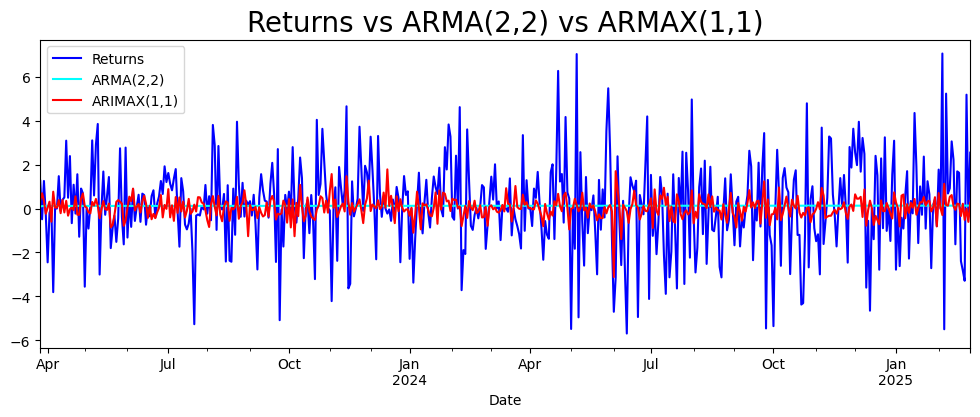

In [ ]:
modelo_ret_ar_1_ma_1_x = SARIMAX(df_train["returns"], exog= df_train["ipc_returns"], order=(1, 0, 1), trend='ct')
results_ret_ar_1_ma_1_x = modelo_ret_ar_1_ma_1_x.fit()
print(results_ret_ar_1_ma_1_x.summary())

# Predecir out-of-sample
start_idx = len(df_train)  # Índice numérico donde comienza la prueba

pred = results_ret_ar_1_ma_1_x.get_prediction(
    start=start_idx,
    end=start_idx + len(df_test) - 1,
    exog=df_test["ipc_returns"]
)
pred_ret_ar_1_ma_1_x = pred.predicted_mean

# Asignar fechas a las predicciones
pred_ret_ar_1_ma_1_x.index = df_test.index

#-----------------------------------------------------------------------------------------

modelo_ret_ar_2_ma_2 = SARIMAX(df_train["returns"], order=(2, 0, 2), trend='ct')
results_ret_ar_2_ma_2= modelo_ret_ar_2_ma_2.fit()
print(results_ret_ar_2_ma_2.summary())

pred_1 = results_ret_ar_2_ma_2.get_prediction(
    start=start_idx,
    end=start_idx + len(df_test) - 1,
)

pred_ret_ar_2_ma_2 = pred_1.predicted_mean

# Asignar fechas a las predicciones
pred_ret_ar_2_ma_2.index = df_test.index

print("MSE de ARMAX(1,1)", mean_squared_error(df_test["returns"], pred_ret_ar_1_ma_1_x))
print("MSE de ARMA(2,2)", mean_squared_error(df_test["returns"], pred_ret_ar_2_ma_2))


# Gráficando predicciones-----------------------------------------------------------------
df_test["returns"].plot(color= "blue")
pred_ret_ar_2_ma_2.plot(color="cyan")
pred_ret_ar_1_ma_1_x.plot(figsize=(12,4), color= "red")

plt.legend(["Returns", "ARMA(2,2)", "ARIMAX(1,1)"])
plt.title("Returns vs ARMA(2,2) vs ARMAX(1,1)", size= 20)
plt.show()


**Conclusión**

Claramente el modelo ARIMAX es mejor que ARMA el problema de los modelos que usan variables exogenas es que se tiene que agregar en la parte de predict, lo que causa problemas a predecir datos que van más alla del presente dado que los vamos a desconcer no sabemos el valor de los demás precios de indicadores.

## Forecasting Volatility

In [122]:
model_garch_1_2 = arch_model(df_train["returns"], mean= "constant", vol= "GARCH", p=1, q=2, dist= "Normal")
# Última fecha de entrenamiento = día anterior a start_date
last_train_date = pd.to_datetime(start_date) - pd.Timedelta(days=1)

results_garch_1_2= model_garch_1_2.fit(last_obs=last_train_date, update_freq= 10)
results_garch_1_2.summary()


Iteration:     10,   Func. Count:     72,   Neg. LLF: 3836.61272740061
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3836.612727401437
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3836.61
Distribution:                  Normal   AIC:                           7683.23
Method:            Maximum Likelihood   BIC:                           7711.24
                                        No. Observations:                 2005
Date:                Fri, Mar 21 2025   Df Residuals:                     2004
Time:                        20:27:10   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1175  3.419e-02      3.438  5.865e-04 [5.052e-02,  0.185]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2977  9.635e-02      3.090  2.005e-03   [  0.109,  0.486]
alpha[1]       0.1717  3.726e-02      4.608  4.070e-06 [9.866e-02,  0.245]
beta[1]        0.4954      0.108      4.580  4.658e-06   [  0.283,  0.707]
beta[2]        0.2406      0.102      2.347  1.891e-02 [3.970e-02,  0.441]
==========================================================================

Covariance estimator: robust
"""

### Predicción al número total de días con respecto al periodo de test

In [123]:
model_garch_1_2 = arch_model(df_train["returns"], mean= "constant", vol= "GARCH", p=1, q=2, dist= "Normal")
results_garch_1_2 = model_garch_1_2.fit(last_obs="2023-03-27", update_freq= 10)

# Establece el horizonte igual al número de días hábiles del conjunto de prueba
horizon = len(df_test)

# Genera el pronóstico para un horizonte de múltiples pasos
pred_garch = results_garch_1_2.forecast(
    horizon=horizon,  
    method='analytic',  
    reindex=False  # Evita que se realinee al índice del entrenamiento
)

# Extrae la predicción del último día de entrenamiento (fila final)
vol_pred = pred_garch.variance.iloc[-1].T

# Asigna el índice del conjunto de prueba a las predicciones
vol_pred.index = df_test.index

print(vol_pred)

Iteration:     10,   Func. Count:     72,   Neg. LLF: 3836.61272740061
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3836.612727401437
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
Date
2023-03-28    2.297915
2023-03-29    2.439794
2023-03-30    2.478063
2023-03-31    2.537723
2023-04-03    2.586729
                ...   
2025-02-20    3.223942
2025-02-21    3.223942
2025-02-24    3.223942
2025-02-25    3.223942
2025-02-26    3.223942
Freq: B, Name: 2023-03-27 00:00:00, Length: 502, dtype: float64


2. Pronóstico Rolling (ventana móvil)
Otra opción es actualizar el modelo de forma secuencial. Es decir, cada vez que dispongas de una nueva observación (al comienzo de cada día del período de prueba), reestimas o actualizas el modelo y generas un pronóstico a un paso. Esto se conoce como pronóstico rolling y permite que el modelo se ajuste a la evolución reciente de los datos. Aunque es computacionalmente más intensivo, puede mejorar la precisión en entornos con cambios dinámicos.

In [124]:
# Lista para almacenar las predicciones
vol_pred_list = []

# Iterar sobre cada fecha del conjunto de prueba
for date in df_test.index:
    # Combina datos de entrenamiento y hasta la fecha actual de prueba
    current_data = pd.concat([df_train["returns"], df_test.loc[:date, "returns"]])
    
    # Ajusta el modelo con los datos actuales (o bien actualiza el modelo)
    model = arch_model(current_data, mean="constant", vol="GARCH", p=1, q=1, dist="Normal")
    results = model.fit(disp="off")
    
    # Pronostica un paso adelante
    pred = results.forecast(horizon=1, method="analytic", reindex=False)
    # Extrae la varianza pronosticada del último día
    vol_pred_list.append(pred.variance.iloc[-1]["h.1"])

# Convierte la lista a una Serie con el índice de df_test
vol_pred_rolling = pd.Series(vol_pred_list, index=df_test.index)
print(vol_pred_rolling)

Date
2023-03-28    2.216783
2023-03-29    2.029304
2023-03-30    2.019572
2023-03-31    1.846010
2023-04-03    2.651243
                ...   
2025-02-20    5.507997
2025-02-21    6.208728
2025-02-24    8.702373
2025-02-25    7.165441
2025-02-26    6.726612
Freq: B, Length: 502, dtype: float64


In [125]:
# Lista para almacenar las predicciones
vol_pred_list_1 = []

# Iterar sobre cada fecha del conjunto de prueba
for date in df_test.index:
    # Combina datos de entrenamiento y hasta la fecha actual de prueba
    current_data = pd.concat([df_train["returns"], df_test.loc[:date, "returns"]])
    
    # Ajusta el modelo con los datos actuales (o bien actualiza el modelo)
    model = arch_model(current_data, mean="constant", vol="GARCH", p=1, q=2, dist="Normal")
    results = model.fit(disp="off")
    
    # Pronostica un paso adelante
    pred = results.forecast(horizon=1, method="analytic", reindex=False)
    # Extrae la varianza pronosticada del último día
    vol_pred_list_1.append(pred.variance.iloc[-1]["h.1"])

# Convierte la lista a una Serie con el índice de df_test
vol_pred_rolling_best = pd.Series(vol_pred_list_1, index=df_test.index)
print(vol_pred_rolling_best)

Date
2023-03-28    2.268689
2023-03-29    2.034763
2023-03-30    2.071827
2023-03-31    1.837862
2023-04-03    2.839821
                ...   
2025-02-20    5.752529
2025-02-21    6.470907
2025-02-24    9.281931
2025-02-25    6.430046
2025-02-26    6.949380
Freq: B, Length: 502, dtype: float64


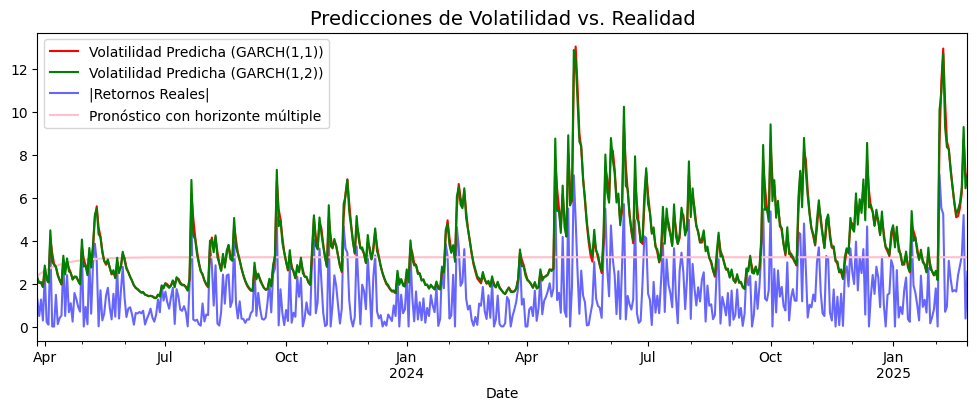

In [126]:
# Graficar
plt.figure(figsize=(12, 4))
vol_pred_rolling.plot(color="red", zorder=2, label="Volatilidad Predicha (GARCH(1,1))")
vol_pred_rolling_best.plot(color="green", zorder=2, label="Volatilidad Predicha (GARCH(1,2))")
df_test["returns"].abs().plot(color="blue", zorder=1, alpha=0.6, label="|Retornos Reales|")
vol_pred.plot(color= "pink", zorder=1, label="Pronóstico con horizonte múltiple")
plt.title("Predicciones de Volatilidad vs. Realidad", size=14)
plt.legend()
plt.show()

In [127]:
print(mean_squared_error(df_test["returns"], vol_pred_rolling))
print(mean_squared_error(df_test["returns"], vol_pred_rolling_best))

20.53349187624518
20.70650344256698


**Conclusion**

Nuestros modelos un MSE de mayor de 20 siendo mejor el Modelo GARCH(1,1) por 0.17.

## Modelo Prophet

In [128]:
from prophet import Prophet

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [129]:
data = pd.DataFrame()
data["y"] = df_train["Q.MX"]
data["ds"] = df_train.index
data= data.reset_index()
data= data.drop(columns="Date")
data["ds"] = pd.to_datetime(data["ds"])
data = data[['ds', 'y']]
display(data)

,ds,y
0,2015-07-20,20.915588
1,2015-07-21,20.870396
2,2015-07-22,20.953247
3,2015-07-23,20.923119
4,2015-07-24,20.877928
...,...,...
2001,2023-03-21,106.274971
2002,2023-03-22,104.380974
2003,2023-03-23,104.914238
2004,2023-03-24,104.546471


In [130]:
m= Prophet()
m.fit(data)

20:27:39 - cmdstanpy - INFO - Chain [1] start processing
20:27:39 - cmdstanpy - INFO - Chain [1] done processing


In [131]:
#Paso 1: Crear el dataframe donde colocaremos nuestros resultados

future= m.make_future_dataframe(periods=502, freq="B")

In [132]:
# vemos que está la parte de entrenamiento más los periodos de predicción que son la última fecha del df_test
display(future)

,ds
0,2015-07-20
1,2015-07-21
2,2015-07-22
3,2015-07-23
4,2015-07-24
...,...
2503,2025-02-20
2504,2025-02-21
2505,2025-02-24
2506,2025-02-25


In [133]:
forecast= m.predict(future)

In [134]:
display(forecast)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-20,23.132159,15.482204,25.904355,23.132159,23.132159,-2.448251,-2.448251,-2.448251,0.509144,0.509144,0.509144,-2.957395,-2.957395,-2.957395,0.0,0.0,0.0,20.683908
1,2015-07-21,23.081131,15.338304,25.602647,23.081131,23.081131,-2.504653,-2.504653,-2.504653,0.444049,0.444049,0.444049,-2.948702,-2.948702,-2.948702,0.0,0.0,0.0,20.576478
2,2015-07-22,23.030102,15.354055,26.054584,23.030102,23.030102,-2.393241,-2.393241,-2.393241,0.537880,0.537880,0.537880,-2.931120,-2.931120,-2.931120,0.0,0.0,0.0,20.636862
3,2015-07-23,22.979074,15.645420,25.722001,22.979074,22.979074,-2.385558,-2.385558,-2.385558,0.519275,0.519275,0.519275,-2.904833,-2.904833,-2.904833,0.0,0.0,0.0,20.593516
4,2015-07-24,22.928046,15.487077,25.639910,22.928046,22.928046,-2.307180,-2.307180,-2.307180,0.563030,0.563030,0.563030,-2.870210,-2.870210,-2.870210,0.0,0.0,0.0,20.620866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,2025-02-20,84.007844,38.317461,141.001111,30.667969,132.016204,7.292256,7.292256,7.292256,0.519275,0.519275,0.519275,6.772980,6.772980,6.772980,0.0,0.0,0.0,91.300100
2504,2025-02-21,84.005032,35.708369,139.868504,30.459086,132.215421,7.375323,7.375323,7.375323,0.563030,0.563030,0.563030,6.812293,6.812293,6.812293,0.0,0.0,0.0,91.380355
2505,2025-02-24,83.996596,36.810295,139.645393,30.246825,132.409014,7.401081,7.401081,7.401081,0.509144,0.509144,0.509144,6.891937,6.891937,6.891937,0.0,0.0,0.0,91.397677
2506,2025-02-25,83.993784,35.429447,141.512991,30.114298,132.608231,7.350077,7.350077,7.350077,0.444049,0.444049,0.444049,6.906028,6.906028,6.906028,0.0,0.0,0.0,91.343861


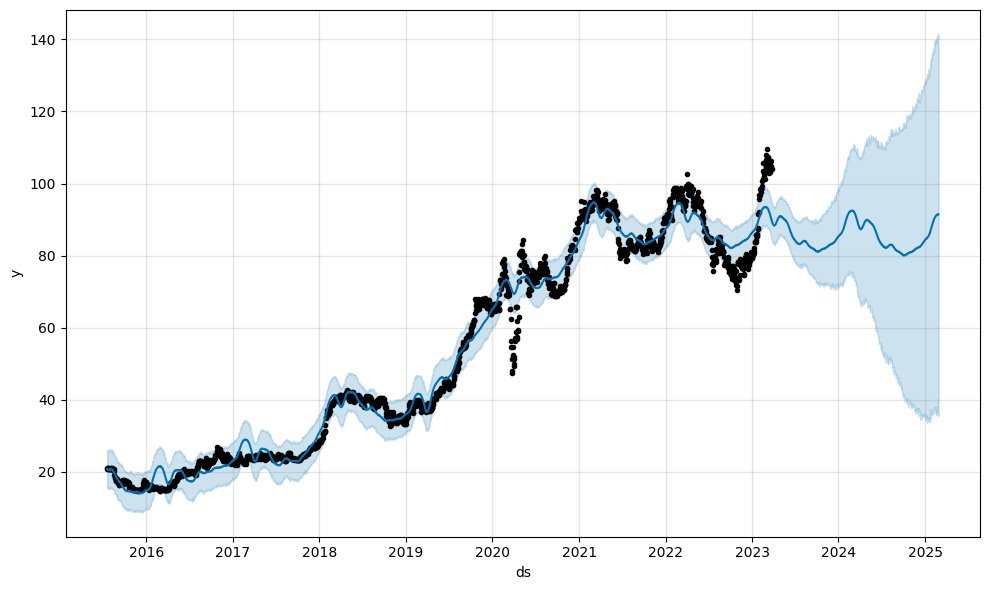

In [135]:
m.plot(forecast)
plt.show()

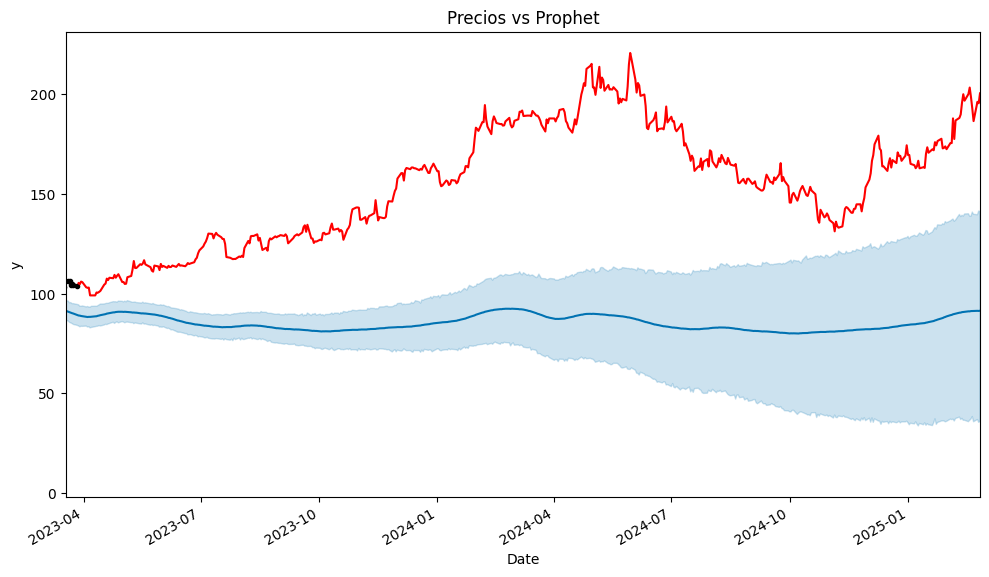

In [136]:
m.plot(forecast)
df_test["Q.MX"].plot(color= "red", label="Precios reales")
plt.xlim(("2023-03-18", "2025-02-26"))
plt.title("Precios vs Prophet")
plt.show()

**Conclusión**

El modelo no hace buenas predicciones.